In [12]:
import os
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2

# 1. 設定
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 25
LR = 1e-3 # 初始學習率調小一點，求穩

base_path = "/kaggle/input/csiro-biomass"
train_csv = os.path.join(base_path, "train.csv")
image_root = base_path

# ===========================
# 2. 資料準備 (Target Z-Score Scaling)
# ===========================
print("正在準備 Baseline 資料...")
df = pd.read_csv(train_csv)

# 切分資料
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# ★★★ 關鍵修改：使用 StandardScaler 對 Target 進行標準化 ★★★
# 這能讓模型訓練極度穩定，避免 R2 變成負數
target_scaler = StandardScaler()
train_target_scaled = target_scaler.fit_transform(train_df[['target']].values)
val_target_scaled = target_scaler.transform(val_df[['target']].values)

train_df['target_scaled'] = train_target_scaled
val_df['target_scaled'] = val_target_scaled

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# ===========================
# 3. Dataset 定義
# ===========================
class BaselineDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.data = df
        self.root_dir = root_dir
        self.transform = transform
        
        self.img_paths = self.data['image_path'].values
        # 訓練用 Scaled Target
        self.targets = torch.tensor(self.data['target_scaled'].values, dtype=torch.float32)
        # 驗證用 Raw Target
        self.raw_targets = torch.tensor(self.data['target'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.img_paths[idx])
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE))
            
        if self.transform:
            image = self.transform(image)
            
        return image, self.targets[idx], self.raw_targets[idx]

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = BaselineDataset(train_df, image_root, train_transform)
val_dataset = BaselineDataset(val_df, image_root, val_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

正在準備 Baseline 資料...


In [13]:
# =============================
# ResNet18 基線模型 (Stabilized Baseline)
# 策略：Target Z-Score + ReduceLROnPlateau
# =============================
# ===========================
# 4. 模型定義 (純 ResNet18 + GradCAM Hook)
# ===========================
class ResNet18_Baseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_ftrs, 1)
        
        self.gradients = None
        self.activations = None

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        if x.requires_grad:
            h = x.register_hook(self.activations_hook)
        self.activations = x
        
        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.backbone.fc(x)
        return x
    
    def get_cam(self):
        gradients = self.gradients.cpu().data.numpy()
        activations = self.activations.cpu().data.numpy()
        weights = np.mean(gradients, axis=(2, 3))[0, :]
        cam = np.zeros(activations.shape[2:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[0, i, :, :]
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-8)
        return cam

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


🚀 開始訓練改良版 ResNet18 Baseline (目標: 穩定收斂 > 0.2)...


Epoch 1: 100%|██████████| 45/45 [00:45<00:00,  1.02s/it]


Epoch 1 | Loss: 1.3200 | RMSE: 27.4214 | R²: -0.1168 ➡ Saved Best!


Epoch 2: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


Epoch 2 | Loss: 0.9078 | RMSE: 24.7955 | R²: 0.0868 ➡ Saved Best!


Epoch 3: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


Epoch 3 | Loss: 0.8641 | RMSE: 24.0981 | R²: 0.1375 ➡ Saved Best!


Epoch 4: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


Epoch 4 | Loss: 0.8979 | RMSE: 24.1398 | R²: 0.1345 


Epoch 5: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 5 | Loss: 0.8614 | RMSE: 24.1958 | R²: 0.1305 


Epoch 6: 100%|██████████| 45/45 [00:43<00:00,  1.04it/s]


Epoch 6 | Loss: 0.8385 | RMSE: 24.3310 | R²: 0.1207 


Epoch 7: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


Epoch 7 | Loss: 0.8629 | RMSE: 23.7039 | R²: 0.1655 ➡ Saved Best!


Epoch 8: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 8 | Loss: 0.8448 | RMSE: 23.0628 | R²: 0.2100 ➡ Saved Best!


Epoch 9: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


Epoch 9 | Loss: 0.8135 | RMSE: 24.6988 | R²: 0.0939 


Epoch 10: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 10 | Loss: 0.8261 | RMSE: 23.0547 | R²: 0.2105 ➡ Saved Best!


Epoch 11: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s]


Epoch 11 | Loss: 0.8454 | RMSE: 23.6835 | R²: 0.1669 


Epoch 12: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


Epoch 12 | Loss: 0.8402 | RMSE: 23.3947 | R²: 0.1871 


Epoch 13: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


Epoch 13 | Loss: 0.8163 | RMSE: 24.8783 | R²: 0.0807 


Epoch 14: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


Epoch 14 | Loss: 0.8069 | RMSE: 23.3478 | R²: 0.1903 


Epoch 15: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


Epoch 15 | Loss: 0.7894 | RMSE: 25.4951 | R²: 0.0346 


Epoch 16: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 16 | Loss: 0.7766 | RMSE: 25.2111 | R²: 0.0560 


Epoch 17: 100%|██████████| 45/45 [00:41<00:00,  1.07it/s]


Epoch 17 | Loss: 0.7568 | RMSE: 22.8422 | R²: 0.2250 ➡ Saved Best!


Epoch 18: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 18 | Loss: 0.7387 | RMSE: 23.4551 | R²: 0.1829 


Epoch 19: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


Epoch 19 | Loss: 0.7118 | RMSE: 23.5535 | R²: 0.1760 


Epoch 20: 100%|██████████| 45/45 [00:41<00:00,  1.08it/s]


Epoch 20 | Loss: 0.7240 | RMSE: 24.7717 | R²: 0.0886 


Epoch 21: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 21 | Loss: 0.7274 | RMSE: 23.1179 | R²: 0.2062 


Epoch 22: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


Epoch 22 | Loss: 0.7454 | RMSE: 26.0965 | R²: -0.0115 


Epoch 23: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 23 | Loss: 0.7131 | RMSE: 23.4314 | R²: 0.1845 


Epoch 24: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 24 | Loss: 0.6810 | RMSE: 24.1004 | R²: 0.1373 


Epoch 25: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


Epoch 25 | Loss: 0.7001 | RMSE: 24.1248 | R²: 0.1356 


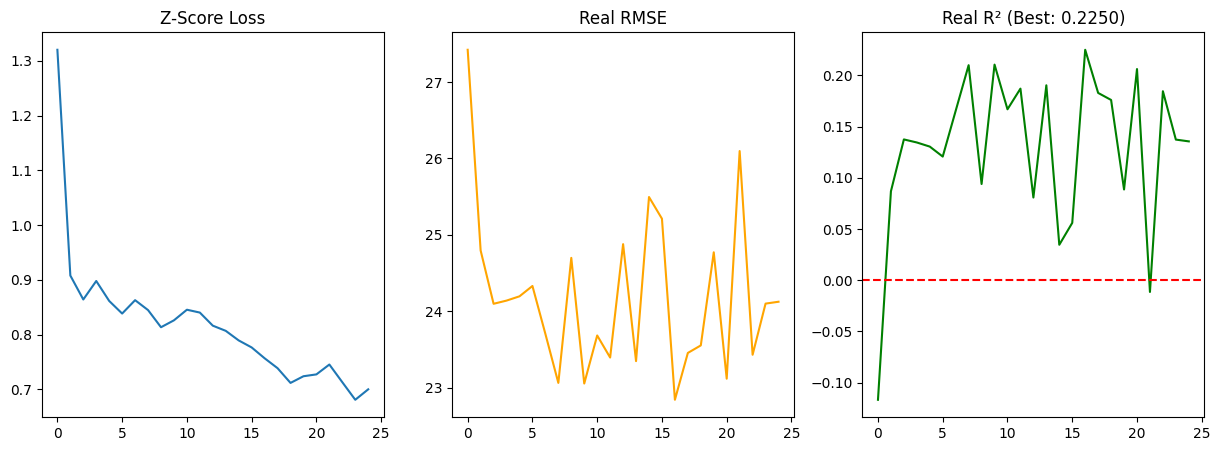


=== ResNet18 Baseline Attention (Grad-CAM) ===


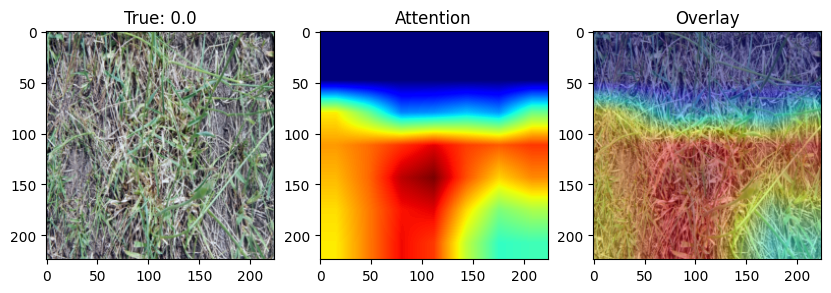

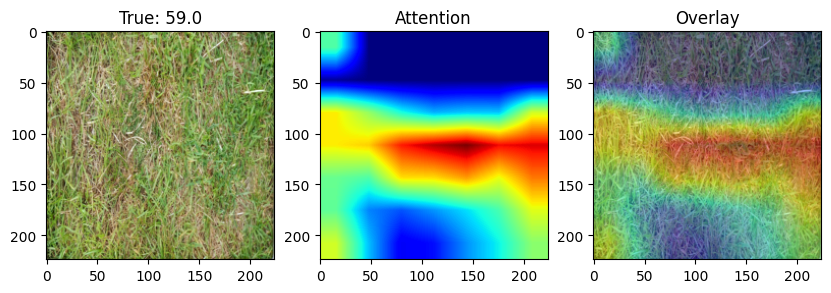

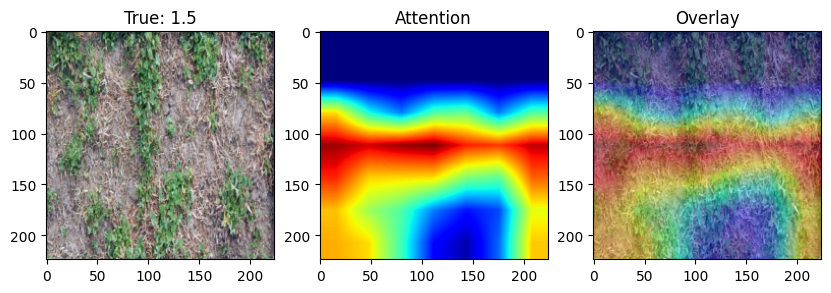

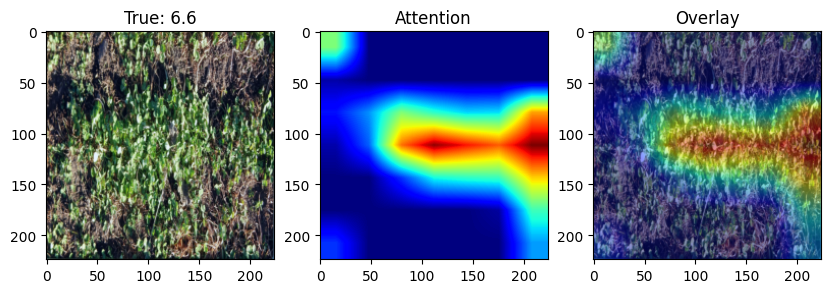

In [5]:
# ===========================
# 5. 訓練流程
# ===========================
model = ResNet18_Baseline().to(device)
criterion = nn.MSELoss() # 因為 Target 已標準化，MSE 最準
optimizer = optim.Adam(model.parameters(), lr=LR)
# ★★★ 改用 ReduceLROnPlateau (更穩定) ★★★
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

train_losses, val_rmses, val_r2s = [], [], []
best_r2 = -float('inf')

print(f"🚀 開始訓練改良版 ResNet18 Baseline (目標: 穩定收斂 > 0.2)...")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    
    for imgs, targets, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs, targets = imgs.to(device), targets.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    
    # 驗證
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for imgs, _, raw_targets in val_loader:
            imgs = imgs.to(device)
            preds_scaled = model(imgs).cpu().numpy()
            
            # ★ 反標準化 (還原成真實數值) ★
            preds_real = target_scaler.inverse_transform(preds_scaled)
            
            all_preds.append(preds_real)
            all_targets.append(raw_targets.numpy())
            
    all_preds = np.concatenate(all_preds).flatten()
    all_targets = np.concatenate(all_targets).flatten()
    all_preds = np.clip(all_preds, 0, None)
    
    mse = np.mean((all_targets - all_preds)**2)
    rmse = np.sqrt(mse)
    ss_res = np.sum((all_targets - all_preds)**2)
    ss_tot = np.sum((all_targets - np.mean(all_targets))**2)
    r2 = 1 - ss_res / (ss_tot + 1e-8)
    
    train_losses.append(train_loss)
    val_rmses.append(rmse)
    val_r2s.append(r2)
    
    save_msg = ""
    if r2 > best_r2:
        best_r2 = r2
        torch.save(model.state_dict(), "/kaggle/working/best_baseline_resnet18.pth")
        save_msg = "➡ Saved Best!"
        
    print(f"Epoch {epoch+1} | Loss: {train_loss:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f} {save_msg}")
    
    # 監控 R2，如果沒進步就降 LR
    scheduler.step(r2)

# ===========================
# 6. 可視化 (趨勢 + 疊圖)
# ===========================
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1); plt.plot(train_losses); plt.title('Z-Score Loss')
plt.subplot(1,3,2); plt.plot(val_rmses, color='orange'); plt.title('Real RMSE')
plt.subplot(1,3,3); plt.plot(val_r2s, color='green'); plt.title(f'Real R² (Best: {best_r2:.4f})'); plt.axhline(0, c='r', ls='--')
plt.show()

print("\n=== ResNet18 Baseline Attention (Grad-CAM) ===")
# 載入最佳權重
model.load_state_dict(torch.load("/kaggle/working/best_baseline_resnet18.pth"))
model.eval()

# 隨機抽樣
temp_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)
imgs, _, raw_targets = next(iter(temp_loader))
imgs = imgs.to(device)

for i in range(4):
    img_tensor = imgs[i].unsqueeze(0).requires_grad_(True)
    
    model.zero_grad()
    out = model(img_tensor)
    out.backward()
    cam = model.get_cam()
    
    img_np = img_tensor.detach().cpu().squeeze().permute(1,2,0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]
    overlay = 0.6 * img_np + 0.4 * heatmap
    
    plt.figure(figsize=(10, 3))
    plt.subplot(1,3,1); plt.imshow(img_np); plt.title(f"True: {raw_targets[i].item():.1f}")
    plt.subplot(1,3,2); plt.imshow(cam, cmap='jet'); plt.title("Attention")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title("Overlay")
    plt.show()

In [14]:
# =============================
# SMA模型
# =============================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---- Model (same as before) ----
class SoftMaskAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.mask = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 2, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        mask = self.mask(x)            # [B,1,H,W], values in (0,1)
        return x * mask, mask          # return (attended_features, mask)

class SMA_ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.layer0 = nn.Sequential(
            self.backbone.conv1,
            self.backbone.bn1,
            self.backbone.relu,
            self.backbone.maxpool
        )
        self.layer1 = self.backbone.layer1
        self.layer2 = self.backbone.layer2
        self.layer3 = self.backbone.layer3
        self.layer4 = self.backbone.layer4
        self.sma = SoftMaskAttention(in_channels=256)
        self.avgpool = self.backbone.avgpool
        self.fc = nn.Linear(self.backbone.fc.in_features, 1)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x, mask = self.sma(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        out = self.fc(x)
        return out, mask

# ---- Smoothed pseudo-mask generator ----
def get_pseudo_green_mask_smoothed(img_tensor, threshold=0.18, smooth_kernel=7):
    device = img_tensor.device
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)
    x = img_tensor * std + mean
    r, g, b = x[:,0,...], x[:,1,...], x[:,2,...]
    raw = ((g > r) & (g > b) & (g > threshold)).float()
    pad = smooth_kernel // 2
    smoothed = F.avg_pool2d(raw.unsqueeze(1), kernel_size=smooth_kernel, stride=1, padding=pad)
    smoothed = torch.clamp(smoothed, 0.0, 1.0)
    return smoothed

Using device: cuda


Using device: cuda
🚀 Start improved SMA training (warmup -> unfreeze -> finetune)
TOTAL_EPOCHS=25, WARMUP=5, FINETUNE_LR=0.0001, MASK_LOSS_WEIGHT=0.25


Epoch 1/25: 100%|██████████| 45/45 [00:41<00:00,  1.08it/s, bio=0.5440, mask=0.6078]


Epoch 1 | Train Loss: 1.6998 | Val Loss: 1.0229 | Val RMSE: 25.5483 | R²: 0.0305 ➡ Saved Best!


Epoch 2/25: 100%|██████████| 45/45 [00:41<00:00,  1.09it/s, bio=0.3433, mask=0.4923]


Epoch 2 | Train Loss: 1.0826 | Val Loss: 1.1732 | Val RMSE: 26.3330 | R²: -0.0299 


Epoch 3/25: 100%|██████████| 45/45 [00:41<00:00,  1.09it/s, bio=0.8838, mask=0.5472]


Epoch 3 | Train Loss: 1.0124 | Val Loss: 0.9806 | Val RMSE: 24.5629 | R²: 0.1039 ➡ Saved Best!


Epoch 4/25: 100%|██████████| 45/45 [00:41<00:00,  1.08it/s, bio=0.6069, mask=0.4947]


Epoch 4 | Train Loss: 0.9999 | Val Loss: 0.8369 | Val RMSE: 23.5841 | R²: 0.1739 ➡ Saved Best!


Epoch 5/25: 100%|██████████| 45/45 [00:41<00:00,  1.08it/s, bio=0.4602, mask=0.3667]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 5 | Train Loss: 0.9730 | Val Loss: 0.8072 | Val RMSE: 23.1615 | R²: 0.2032 ➡ Saved Best!

=== Phase 2: Unfreeze backbone & finetune ===


Epoch 6/25: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s, bio=0.5714, mask=0.3956]


Epoch 6 | Train Loss: 0.8970 | Val Loss: 0.7466 | Val RMSE: 22.2752 | R²: 0.2630 ➡ Saved Best!


Epoch 7/25: 100%|██████████| 45/45 [00:41<00:00,  1.08it/s, bio=0.6297, mask=0.4391]


Epoch 7 | Train Loss: 0.8561 | Val Loss: 0.7572 | Val RMSE: 22.4321 | R²: 0.2526 


Epoch 8/25: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s, bio=1.6132, mask=0.3584]


Epoch 8 | Train Loss: 0.8659 | Val Loss: 0.7977 | Val RMSE: 23.0251 | R²: 0.2126 


Epoch 9/25: 100%|██████████| 45/45 [00:41<00:00,  1.08it/s, bio=0.6653, mask=0.4017]


Epoch 9 | Train Loss: 0.8618 | Val Loss: 0.8246 | Val RMSE: 23.4094 | R²: 0.1861 


Epoch 10/25: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s, bio=0.6238, mask=0.4062]


Epoch 10 | Train Loss: 0.8311 | Val Loss: 0.8072 | Val RMSE: 23.1616 | R²: 0.2032 


Epoch 11/25: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s, bio=0.9622, mask=0.3497]


Epoch 11 | Train Loss: 0.8304 | Val Loss: 0.7615 | Val RMSE: 22.4969 | R²: 0.2483 


Epoch 12/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, bio=0.5007, mask=0.3640]


Epoch 12 | Train Loss: 0.8142 | Val Loss: 0.7715 | Val RMSE: 22.6440 | R²: 0.2384 


Epoch 13/25: 100%|██████████| 45/45 [00:41<00:00,  1.07it/s, bio=0.7167, mask=0.3777]


Epoch 13 | Train Loss: 0.7988 | Val Loss: 0.7604 | Val RMSE: 22.4807 | R²: 0.2494 


Epoch 14/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, bio=0.6572, mask=0.3862]


Epoch 14 | Train Loss: 0.8038 | Val Loss: 0.7848 | Val RMSE: 22.8378 | R²: 0.2253 


Epoch 15/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, bio=1.1443, mask=0.3195]


Epoch 15 | Train Loss: 0.7949 | Val Loss: 0.7718 | Val RMSE: 22.6484 | R²: 0.2381 


Epoch 16/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, bio=0.4414, mask=0.3547]


Epoch 16 | Train Loss: 0.7644 | Val Loss: 0.7995 | Val RMSE: 23.0504 | R²: 0.2108 


Epoch 17/25: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s, bio=0.4739, mask=0.3649]


Epoch 17 | Train Loss: 0.7865 | Val Loss: 0.7811 | Val RMSE: 22.7838 | R²: 0.2290 


Epoch 18/25: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s, bio=1.0323, mask=0.3882]


Epoch 18 | Train Loss: 0.7716 | Val Loss: 0.7902 | Val RMSE: 22.9167 | R²: 0.2200 


Epoch 19/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, bio=0.4278, mask=0.4077]


Epoch 19 | Train Loss: 0.7931 | Val Loss: 0.7837 | Val RMSE: 22.8221 | R²: 0.2264 


Epoch 20/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, bio=0.8023, mask=0.4158]


Epoch 20 | Train Loss: 0.7795 | Val Loss: 0.7860 | Val RMSE: 22.8554 | R²: 0.2241 


Epoch 21/25: 100%|██████████| 45/45 [00:41<00:00,  1.07it/s, bio=0.2818, mask=0.3805]


Epoch 21 | Train Loss: 0.7742 | Val Loss: 0.7890 | Val RMSE: 22.8995 | R²: 0.2211 


Epoch 22/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, bio=0.6554, mask=0.3178]


Epoch 22 | Train Loss: 0.7746 | Val Loss: 0.7978 | Val RMSE: 23.0264 | R²: 0.2125 


Epoch 23/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, bio=1.0436, mask=0.3653]


Epoch 23 | Train Loss: 0.7726 | Val Loss: 0.7963 | Val RMSE: 23.0040 | R²: 0.2140 


Epoch 24/25: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s, bio=0.5048, mask=0.3779]


Epoch 24 | Train Loss: 0.7769 | Val Loss: 0.7925 | Val RMSE: 22.9486 | R²: 0.2178 


Epoch 25/25: 100%|██████████| 45/45 [00:41<00:00,  1.07it/s, bio=2.1122, mask=0.3303]


Epoch 25 | Train Loss: 0.7961 | Val Loss: 0.7947 | Val RMSE: 22.9815 | R²: 0.2155 


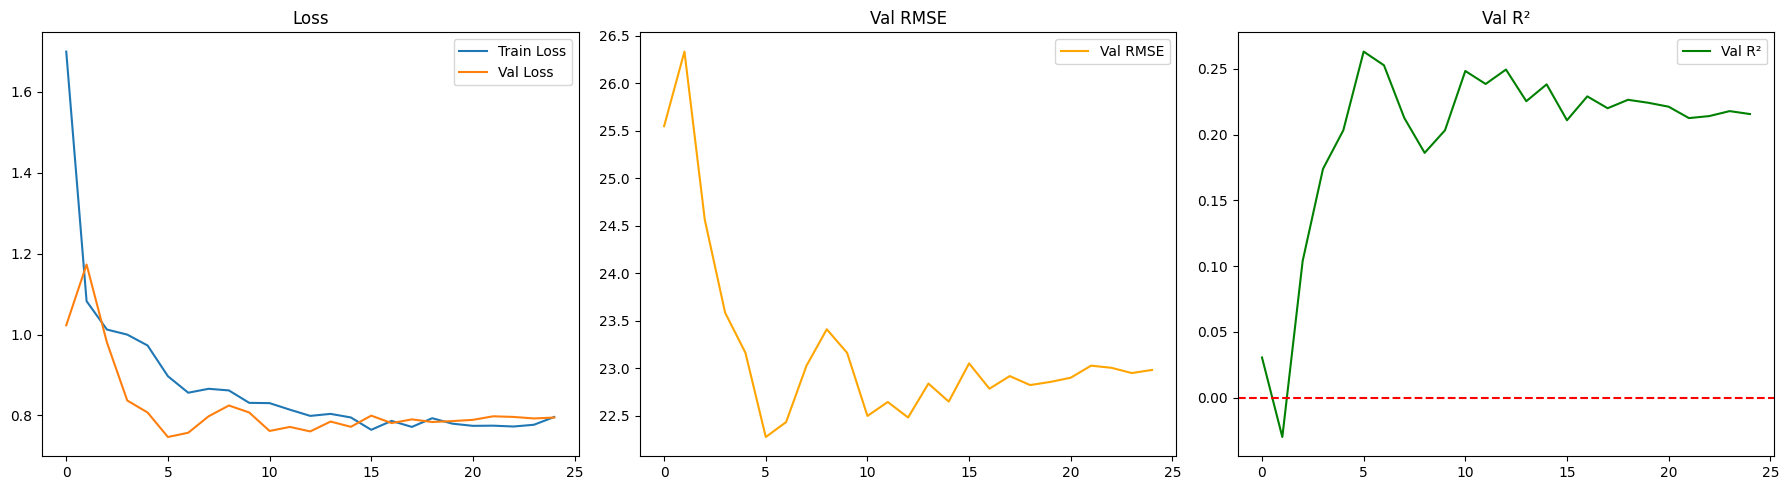

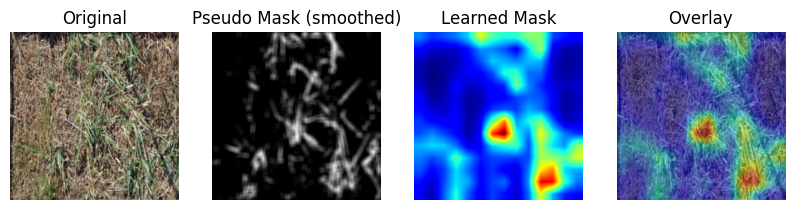

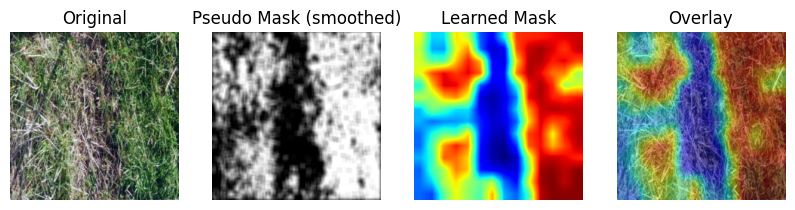

In [ ]:
# ---- Hyperparams ----
WARMUP_EPOCHS = 5
TOTAL_EPOCHS = 25
WARMUP_LR = 1e-3
FINETUNE_LR = 1e-4
MASK_LOSS_WEIGHT = 0.25
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 1.0

# ---- Instantiate model & criterions ----
sma_model = SMA_ResNet18().to(device)
mse_criterion = nn.MSELoss()
bce_criterion = nn.BCELoss()

# ---- Freeze layers for warmup ----
for p in sma_model.layer0.parameters():
    p.requires_grad = False
for p in sma_model.layer1.parameters():
    p.requires_grad = False
for p in sma_model.layer2.parameters():
    p.requires_grad = False

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, sma_model.parameters()), lr=WARMUP_LR, weight_decay=WEIGHT_DECAY)
scheduler = None

# trackers
train_losses, val_losses, val_rmses, val_r2s = [], [], [], []

print("🚀 Start improved SMA training (warmup -> unfreeze -> finetune)")
print(f"TOTAL_EPOCHS={TOTAL_EPOCHS}, WARMUP={WARMUP_EPOCHS}, FINETUNE_LR={FINETUNE_LR}, MASK_LOSS_WEIGHT={MASK_LOSS_WEIGHT}")

best_val_r2 = -float('inf')
best_epoch = -1

for epoch in range(TOTAL_EPOCHS):

    # ---- Phase switch to finetune ----
    if epoch == WARMUP_EPOCHS:
        print("\n=== Phase 2: Unfreeze backbone & finetune ===")
        for p in sma_model.backbone.parameters():
            p.requires_grad = True
        optimizer = optim.AdamW(sma_model.parameters(), lr=FINETUNE_LR, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

    # ---- Train ----
    sma_model.train()
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{TOTAL_EPOCHS}")
    for imgs, targets_scaled, _ in pbar:
        imgs = imgs.to(device)
        targets = targets_scaled.to(device).unsqueeze(1)
        with torch.no_grad():
            pseudo_high = get_pseudo_green_mask_smoothed(imgs, threshold=0.18, smooth_kernel=7)
        optimizer.zero_grad()
        preds_scaled, learned_mask = sma_model(imgs)
        pseudo_low = F.interpolate(pseudo_high, size=learned_mask.shape[-2:], mode='bilinear', align_corners=False)
        loss_bio = mse_criterion(preds_scaled, targets)
        loss_mask = bce_criterion(learned_mask, pseudo_low)
        loss_total = loss_bio + MASK_LOSS_WEIGHT * loss_mask
        loss_total.backward()
        torch.nn.utils.clip_grad_norm_(sma_model.parameters(), max_norm=GRAD_CLIP)
        optimizer.step()
        epoch_loss += loss_total.item() * imgs.size(0)
        pbar.set_postfix({'bio': f"{loss_bio.item():.4f}", 'mask': f"{loss_mask.item():.4f}"})
    epoch_loss /= len(train_loader.dataset)

    # ---- Validation ----
    sma_model.eval()
    val_loss = 0.0
    all_preds_scaled, all_targets_raw = [], []
    vis_imgs, vis_masks, vis_pseu = None, None, None
    with torch.no_grad():
        for i, (imgs, targets_scaled, raw_targets) in enumerate(val_loader):
            imgs = imgs.to(device)
            targets = targets_scaled.to(device).unsqueeze(1)
            outputs_scaled, masks = sma_model(imgs)
            val_loss += mse_criterion(outputs_scaled, targets).item() * imgs.size(0)
            if i == len(val_loader) - 1:
                vis_imgs = imgs.cpu()
                vis_masks = masks.cpu()
                vis_pseu = get_pseudo_green_mask_smoothed(imgs, threshold=0.18, smooth_kernel=7).cpu()
            all_preds_scaled.append(outputs_scaled.cpu().numpy())
            all_targets_raw.append(raw_targets.numpy())
    val_loss /= len(val_loader.dataset)

    all_preds_scaled = np.concatenate(all_preds_scaled).reshape(-1,1)
    preds_real = target_scaler.inverse_transform(all_preds_scaled).flatten()
    all_targets = np.concatenate(all_targets_raw).flatten()
    preds_real = np.clip(preds_real, 0, None)
    val_rmse = np.sqrt(np.mean((all_targets - preds_real)**2))
    ss_res = np.sum((all_targets - preds_real)**2)
    ss_tot = np.sum((all_targets - np.mean(all_targets))**2)
    val_r2 = 1 - ss_res / (ss_tot + 1e-8)

    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
    val_rmses.append(val_rmse)
    val_r2s.append(val_r2)

    # ---- Save best model ----
    save_msg = ""
    if val_r2 > best_val_r2 + 1e-8:
        best_val_r2 = val_r2
        best_epoch = epoch + 1
        torch.save(sma_model.state_dict(), "/kaggle/working/best_sma_resnet18_integrated.pth")
        save_msg = "➡ Saved Best!"

    print(f"Epoch {epoch+1} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val RMSE: {val_rmse:.4f} | R²: {val_r2:.4f} {save_msg}")

    if scheduler is not None:
        scheduler.step(val_r2)

# ---- Plots ----
plt.figure(figsize=(18,5))
plt.subplot(1,3,1); plt.plot(train_losses, label='Train Loss'); plt.plot(val_losses, label='Val Loss'); plt.title('Loss'); plt.legend()
plt.subplot(1,3,2); plt.plot(val_rmses, color='orange', label='Val RMSE'); plt.title('Val RMSE'); plt.legend()
plt.subplot(1,3,3); plt.plot(val_r2s, color='green', label='Val R²'); plt.title('Val R²'); plt.legend(); plt.axhline(0, c='r', ls='--')
plt.tight_layout(); plt.show()

# ---- Mask visualization from last val batch ----
if vis_imgs is not None:
    n_show = min(3, vis_imgs.shape[0])
    for i in range(n_show):
        img_t = vis_imgs[i]
        img_np = img_t.permute(1,2,0).numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

        learned = vis_masks[i].unsqueeze(0)
        learned_up = F.interpolate(learned, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)[0,0].numpy()
        pseudo_up = F.interpolate(vis_pseu[i].unsqueeze(0), size=(IMG_SIZE, IMG_SIZE), mode='nearest')[0,0].numpy()

        plt.figure(figsize=(10,3))
        plt.subplot(1,4,1); plt.imshow(img_np); plt.title("Original"); plt.axis('off')
        plt.subplot(1,4,2); plt.imshow(pseudo_up, cmap='gray'); plt.title("Pseudo Mask (smoothed)"); plt.axis('off')
        plt.subplot(1,4,3); plt.imshow(learned_up, cmap='jet'); plt.title("Learned Mask"); plt.axis('off')
        plt.subplot(1,4,4); plt.imshow(img_np); plt.imshow(learned_up, cmap='jet', alpha=0.45); plt.title("Overlay"); plt.axis('off')
        plt.show()
else:
    print("No validation batch available for mask visualization.")

print(f"\nTraining finished. Best epoch: {best_epoch}, Best Val R²: {best_val_r2:.4f}, Best model saved to /kaggle/working/best_sma_resnet18_integrated.pth")

In [15]:
# =============================
# Multi-Task Learning (Biomass + Cover Ratio) with Soft Mask Attention
# =============================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---- Soft Mask Attention ----
class SoftMaskAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.mask = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 2, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        mask = self.mask(x)         
        x_att = x * mask
        return x_att, mask

# ---- MTL ResNet18 ----
class MTL_ResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.layer0 = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu, backbone.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = backbone.layer1, backbone.layer2, backbone.layer3, backbone.layer4
        self.sma = SoftMaskAttention(in_channels=256)  # conv3 output channels
        self.avgpool = backbone.avgpool
        self.biomass_head = nn.Linear(backbone.fc.in_features, 1)
        self.cover_head   = nn.Linear(backbone.fc.in_features, 1)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x, mask = self.sma(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        biomass = self.biomass_head(x)
        cover_ratio = self.cover_head(x)
        return biomass, cover_ratio, mask

# ---- Pseudo Mask Generator ----
def get_pseudo_green_mask(img_tensor, threshold=0.18, smooth_kernel=7):
    device = img_tensor.device
    mean = torch.tensor([0.485,0.456,0.406], device=device).view(1,3,1,1)
    std  = torch.tensor([0.229,0.224,0.225], device=device).view(1,3,1,1)
    x = img_tensor * std + mean
    r,g,b = x[:,0], x[:,1], x[:,2]
    raw = ((g>r) & (g>b) & (g>threshold)).float()
    pad = smooth_kernel//2
    smoothed = F.avg_pool2d(raw.unsqueeze(1), kernel_size=smooth_kernel, stride=1, padding=pad)
    smoothed = torch.clamp(smoothed, 0.0, 1.0)
    return smoothed

# ---- Hyperparams ----
TOTAL_EPOCHS =  25   
LR = 1e-3
MASK_WEIGHT = 0.25
MTL_WEIGHT = 0.25
GRAD_CLIP = 1.0
BATCH_SIZE = 64        

# ---- Model, Loss, Optimizer ----
mtl_model = MTL_ResNet18().to(device)
mse = nn.MSELoss()
bce = nn.BCELoss()
optimizer = optim.AdamW(mtl_model.parameters(), lr=LR)
scheduler = None

# ---- Trackers ----
train_losses, val_losses, val_rmses, val_r2s = [], [], [], []

best_val_r2 = -float('inf')
best_epoch = -1

Using device: cuda


Epoch 3/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, bio=0.9977, cover=0.0769, mask=0.5533]


Epoch 3 | Train Loss: 1.0769 | Val Loss: 1.0332 | Val RMSE: 26.0725 | R²: -0.0097 ➡ Saved Best!


Epoch 4/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, bio=1.0316, cover=0.0284, mask=0.4866]


Epoch 4 | Train Loss: 1.0919 | Val Loss: 1.0023 | Val RMSE: 25.1226 | R²: 0.0626 ➡ Saved Best!


Epoch 5/25: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s, bio=2.0097, cover=0.0375, mask=0.4713]


Epoch 5 | Train Loss: 1.0647 | Val Loss: 0.9157 | Val RMSE: 24.4102 | R²: 0.1150 ➡ Saved Best!


Epoch 6/25: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s, bio=0.9326, cover=0.0342, mask=0.4943]


Epoch 6 | Train Loss: 1.0574 | Val Loss: 0.9668 | Val RMSE: 25.2642 | R²: 0.0520 


Epoch 7/25: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s, bio=0.5978, cover=0.0080, mask=0.4429]


Epoch 7 | Train Loss: 1.0156 | Val Loss: 0.9318 | Val RMSE: 24.8545 | R²: 0.0825 


Epoch 8/25: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s, bio=0.6355, cover=0.0104, mask=0.3464]


Epoch 8 | Train Loss: 1.0467 | Val Loss: 0.8395 | Val RMSE: 23.5253 | R²: 0.1780 ➡ Saved Best!


Epoch 9/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, bio=0.8469, cover=0.1058, mask=0.5525]


Epoch 9 | Train Loss: 1.0564 | Val Loss: 0.9645 | Val RMSE: 23.8804 | R²: 0.1530 


Epoch 10/25: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s, bio=0.3353, cover=0.0284, mask=0.3682]


Epoch 10 | Train Loss: 1.0171 | Val Loss: 1.3446 | Val RMSE: 24.6511 | R²: 0.0974 


Epoch 11/25: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s, bio=1.0722, cover=0.1047, mask=0.4410]


Epoch 11 | Train Loss: 1.0222 | Val Loss: 0.9884 | Val RMSE: 25.5456 | R²: 0.0307 


Epoch 12/25: 100%|██████████| 45/45 [00:41<00:00,  1.08it/s, bio=1.5936, cover=0.0375, mask=0.4724]


Epoch 12 | Train Loss: 0.9791 | Val Loss: 1.8851 | Val RMSE: 24.3886 | R²: 0.1165 


Epoch 13/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, bio=0.5562, cover=0.0457, mask=0.5093]


Epoch 13 | Train Loss: 0.9861 | Val Loss: 0.8951 | Val RMSE: 24.3408 | R²: 0.1200 


Epoch 14/25: 100%|██████████| 45/45 [00:41<00:00,  1.08it/s, bio=2.0834, cover=0.0077, mask=0.3263]


Epoch 14 | Train Loss: 1.0076 | Val Loss: 1.0983 | Val RMSE: 24.5292 | R²: 0.1063 


Epoch 15/25: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s, bio=1.2284, cover=0.0226, mask=0.2769]


Epoch 15 | Train Loss: 0.9705 | Val Loss: 0.8421 | Val RMSE: 23.6211 | R²: 0.1713 


Epoch 16/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, bio=0.8679, cover=0.0136, mask=0.3428]


Epoch 16 | Train Loss: 0.9458 | Val Loss: 0.8134 | Val RMSE: 23.2270 | R²: 0.1987 ➡ Saved Best!


Epoch 17/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, bio=1.0748, cover=0.0420, mask=0.3417]


Epoch 17 | Train Loss: 0.9629 | Val Loss: 0.8433 | Val RMSE: 23.5965 | R²: 0.1730 


Epoch 18/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, bio=0.5970, cover=0.0407, mask=0.3611]


Epoch 18 | Train Loss: 0.9852 | Val Loss: 0.8437 | Val RMSE: 23.6208 | R²: 0.1713 


Epoch 19/25: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s, bio=0.7698, cover=0.0088, mask=0.3661]


Epoch 19 | Train Loss: 0.9670 | Val Loss: 0.9444 | Val RMSE: 24.9164 | R²: 0.0779 


Epoch 20/25: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s, bio=0.6132, cover=0.0169, mask=0.3398]


Epoch 20 | Train Loss: 0.9527 | Val Loss: 1.1481 | Val RMSE: 26.5799 | R²: -0.0493 


Epoch 21/25: 100%|██████████| 45/45 [00:43<00:00,  1.05it/s, bio=0.5801, cover=0.0397, mask=0.4782]


Epoch 21 | Train Loss: 0.9307 | Val Loss: 0.9550 | Val RMSE: 25.1803 | R²: 0.0583 


Epoch 22/25: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s, bio=0.4723, cover=0.0256, mask=0.3124]


Epoch 22 | Train Loss: 0.9253 | Val Loss: 0.9788 | Val RMSE: 25.1670 | R²: 0.0593 


Epoch 23/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, bio=0.8110, cover=0.0277, mask=0.3469]


Epoch 23 | Train Loss: 0.9253 | Val Loss: 0.9510 | Val RMSE: 25.0936 | R²: 0.0647 


Epoch 24/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, bio=1.1669, cover=0.0253, mask=0.4485]


Epoch 24 | Train Loss: 0.9839 | Val Loss: 1.0633 | Val RMSE: 26.5703 | R²: -0.0486 


Epoch 25/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, bio=0.6087, cover=0.0341, mask=0.4033]


Epoch 25 | Train Loss: 0.9583 | Val Loss: 0.8365 | Val RMSE: 23.5653 | R²: 0.1752 


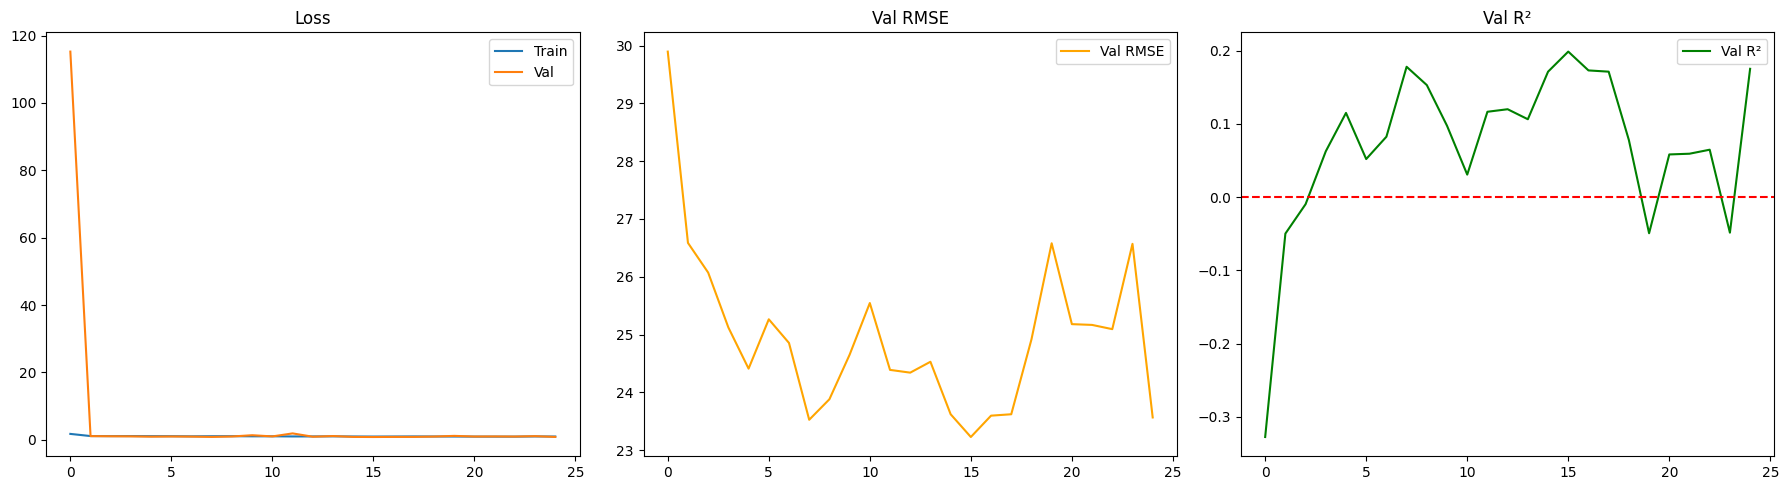

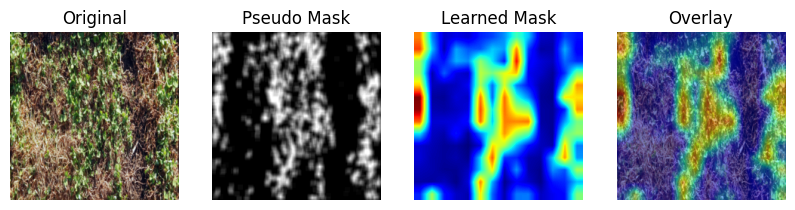

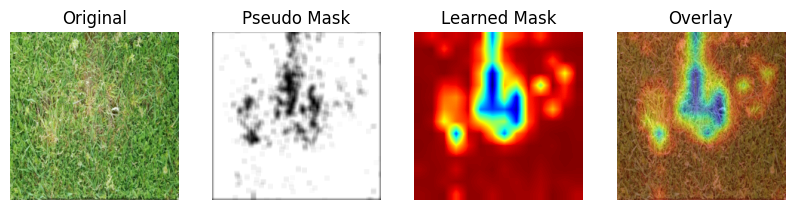

In [ ]:
# =============================
# Training Loop
# =============================
for epoch in range(TOTAL_EPOCHS):
    mtl_model.train()
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{TOTAL_EPOCHS}")
    
    for imgs, targets_scaled, _ in pbar:
        imgs = imgs.to(device)
        biomass_targets = targets_scaled.to(device).unsqueeze(1)

        # pseudo mask 無梯度
        with torch.no_grad():
            pseudo_mask = get_pseudo_green_mask(imgs).to(device)

        optimizer.zero_grad()
        biomass_pred, cover_pred, learned_mask = mtl_model(imgs)
        cover_target = pseudo_mask.view(pseudo_mask.size(0), -1).mean(dim=1, keepdim=True)

        loss_biomass = mse(biomass_pred, biomass_targets)
        loss_cover   = mse(cover_pred, cover_target)
        loss_mask    = bce(learned_mask, F.interpolate(pseudo_mask, size=learned_mask.shape[-2:], mode='bilinear'))

        loss_total = loss_biomass + MTL_WEIGHT*loss_cover + MASK_WEIGHT*loss_mask
        loss_total.backward()
        torch.nn.utils.clip_grad_norm_(mtl_model.parameters(), GRAD_CLIP)
        optimizer.step()
        epoch_loss += loss_total.item() * imgs.size(0)
        pbar.set_postfix({'bio': f"{loss_biomass.item():.4f}", 'cover': f"{loss_cover.item():.4f}", 'mask': f"{loss_mask.item():.4f}"})

        # 清理記憶體
        del pseudo_mask, learned_mask
        torch.cuda.empty_cache()
    
    epoch_loss /= len(train_loader.dataset)

    # ---- Validation ----
    mtl_model.eval()
    val_loss = 0.0
    all_preds, all_targets_raw = [], []
    vis_imgs, vis_masks, vis_pseu = None, None, None

    with torch.no_grad():
        for i, (imgs, targets_scaled, raw_targets) in enumerate(val_loader):
            imgs = imgs.to(device)
            biomass_targets = targets_scaled.to(device).unsqueeze(1)
            biomass_pred, cover_pred, learned_mask = mtl_model(imgs)

            pseudo_mask = get_pseudo_green_mask(imgs).to(device)
            cover_target = pseudo_mask.view(pseudo_mask.size(0), -1).mean(dim=1, keepdim=True)

            val_loss += (mse(biomass_pred, biomass_targets) + MTL_WEIGHT*mse(cover_pred, cover_target)).item() * imgs.size(0)
            
            # 只保留少量影像做可視化
            if i == 0:
                vis_imgs = imgs[:2].cpu()
                vis_masks = learned_mask[:2].cpu()
                vis_pseu = pseudo_mask[:2].cpu()

            all_preds.append(biomass_pred.cpu().numpy())
            all_targets_raw.append(raw_targets.numpy())

            del pseudo_mask, learned_mask
            torch.cuda.empty_cache()

    val_loss /= len(val_loader.dataset)

    all_preds = np.concatenate(all_preds).reshape(-1,1)
    preds_real = target_scaler.inverse_transform(all_preds).flatten()
    all_targets = np.concatenate(all_targets_raw).flatten()
    preds_real = np.clip(preds_real, 0, None)
    val_rmse = np.sqrt(np.mean((all_targets - preds_real)**2))
    ss_res = np.sum((all_targets - preds_real)**2)
    ss_tot = np.sum((all_targets - np.mean(all_targets))**2)
    val_r2 = 1 - ss_res/(ss_tot+1e-8)

    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
    val_rmses.append(val_rmse)
    val_r2s.append(val_r2)

    # Save best
    save_msg = ""
    if val_r2 > best_val_r2 + 1e-8:
        best_val_r2 = val_r2
        best_epoch = epoch+1
        torch.save(mtl_model.state_dict(), "/kaggle/working/best_mtl_resnet18.pth")
        save_msg = "➡ Saved Best!"

    print(f"Epoch {epoch+1} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val RMSE: {val_rmse:.4f} | R²: {val_r2:.4f} {save_msg}")

# ---- Plots ----
plt.figure(figsize=(18,5))
plt.subplot(1,3,1); plt.plot(train_losses,label='Train'); plt.plot(val_losses,label='Val'); plt.title('Loss'); plt.legend()
plt.subplot(1,3,2); plt.plot(val_rmses,color='orange',label='Val RMSE'); plt.title('Val RMSE'); plt.legend()
plt.subplot(1,3,3); plt.plot(val_r2s,color='green',label='Val R²'); plt.title('Val R²'); plt.legend(); plt.axhline(0,c='r',ls='--')
plt.tight_layout(); plt.show()

# ---- Mask visualization ----
if vis_imgs is not None:
    n_show = vis_imgs.shape[0]
    for i in range(n_show):
        img_t = vis_imgs[i].permute(1,2,0).numpy()
        img_t = (img_t-img_t.min())/(img_t.max()-img_t.min())
        learned_up = F.interpolate(vis_masks[i].unsqueeze(0), size=(224,224), mode='bilinear')[0,0].numpy()
        pseudo_up   = F.interpolate(vis_pseu[i].unsqueeze(0), size=(224,224), mode='nearest')[0,0].numpy()
        plt.figure(figsize=(10,3))
        plt.subplot(1,4,1); plt.imshow(img_t); plt.title("Original"); plt.axis('off')
        plt.subplot(1,4,2); plt.imshow(pseudo_up,cmap='gray'); plt.title("Pseudo Mask"); plt.axis('off')
        plt.subplot(1,4,3); plt.imshow(learned_up,cmap='jet'); plt.title("Learned Mask"); plt.axis('off')
        plt.subplot(1,4,4); plt.imshow(img_t); plt.imshow(learned_up,cmap='jet',alpha=0.45); plt.title("Overlay"); plt.axis('off')
        plt.show()

In [16]:
# ==========================
# PastureMask-MTLNet (ResNet18 + SMA + Multi-Task)
# ==========================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------------
# 1. Soft Mask Attention
# --------------------------
class SoftMaskAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.mask = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 2, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        mask = self.mask(x)            
        return x * mask, mask

# --------------------------
# 2. PastureMask-MTLNet
# --------------------------
class PastureMask_MTLNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.layer0 = nn.Sequential(
            self.backbone.conv1,
            self.backbone.bn1,
            self.backbone.relu,
            self.backbone.maxpool
        )
        self.layer1 = self.backbone.layer1
        self.layer2 = self.backbone.layer2
        self.layer3 = self.backbone.layer3
        self.layer4 = self.backbone.layer4
        self.sma = SoftMaskAttention(in_channels=256)
        self.avgpool = self.backbone.avgpool
        feat_dim = self.backbone.fc.in_features
        self.fc_biomass = nn.Linear(feat_dim, 1)
        self.fc_cover   = nn.Linear(feat_dim, 1)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x, mask = self.sma(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        out_biomass = self.fc_biomass(x)
        out_cover   = self.fc_cover(x)
        return out_biomass, out_cover, mask

# --------------------------
# 3. Pseudo mask generation (弱監督)
# --------------------------
def get_pseudo_green_mask(img_tensor, threshold=0.18, smooth_kernel=7):
    with torch.no_grad():  
        device = img_tensor.device
        mean = torch.tensor([0.485,0.456,0.406], device=device).view(1,3,1,1)
        std  = torch.tensor([0.229,0.224,0.225], device=device).view(1,3,1,1)
        x = img_tensor * std + mean
        r, g, b = x[:,0,...], x[:,1,...], x[:,2,...]
        raw = ((g > r) & (g > b) & (g > threshold)).float()
        pad = smooth_kernel // 2
        smoothed = F.avg_pool2d(raw.unsqueeze(1), kernel_size=smooth_kernel, stride=1, padding=pad)
        return torch.clamp(smoothed, 0.0, 1.0)

Using device: cuda


Using device: cuda


Epoch 1/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/25:  98%|█████████▊| 44/45 [00:41<00:00,  1.29it/s, biomass=0.9807, cover=0.1272, mask=0.5721]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/25: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s, biomass=2.0197, cover=0.0872, mask=0.5999]


Epoch 1 | Train Loss: 1.6468 | Val RMSE: 24.5175 | R²: 0.1072 ➡ Saved Best!


Epoch 2/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 2/25:  98%|█████████▊| 44/45 [00:41<00:00,  1.28it/s, biomass=0.8995, cover=0.1106, mask=0.4555]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 2/25: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s, biomass=0.9113, cover=0.0685, mask=0.4644]


Epoch 2 | Train Loss: 1.1617 | Val RMSE: 25.4960 | R²: 0.0345 


Epoch 3/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 3/25:  98%|█████████▊| 44/45 [00:41<00:00,  1.28it/s, biomass=0.7855, cover=0.1297, mask=0.3991]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 3/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, biomass=1.2553, cover=0.1496, mask=0.4569]


Epoch 3 | Train Loss: 1.0943 | Val RMSE: 24.5912 | R²: 0.1018 


Epoch 4/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 4/25:  98%|█████████▊| 44/45 [00:41<00:00,  1.26it/s, biomass=1.6654, cover=0.1139, mask=0.4888]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 4/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, biomass=1.3152, cover=0.0908, mask=0.3965]


Epoch 4 | Train Loss: 1.1063 | Val RMSE: 25.8013 | R²: 0.0112 


Epoch 5/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 5/25:  98%|█████████▊| 44/45 [00:41<00:00,  1.25it/s, biomass=0.6731, cover=0.1085, mask=0.3701]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 5/25: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s, biomass=0.5544, cover=0.1655, mask=0.4149]


Epoch 5 | Train Loss: 1.0828 | Val RMSE: 23.6386 | R²: 0.1700 ➡ Saved Best!


Epoch 6/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 6/25:  98%|█████████▊| 44/45 [00:41<00:00,  1.24it/s, biomass=0.8543, cover=0.1232, mask=0.4084]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 6/25: 100%|██████████| 45/45 [00:42<00:00,  1.05it/s, biomass=0.8360, cover=0.1317, mask=0.3687]


Epoch 6 | Train Loss: 1.0635 | Val RMSE: 24.5612 | R²: 0.1040 


Epoch 7/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 7/25:  98%|█████████▊| 44/45 [00:41<00:00,  1.27it/s, biomass=1.9882, cover=0.1062, mask=0.3796]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 7/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, biomass=0.6267, cover=0.1369, mask=0.3860]


Epoch 7 | Train Loss: 1.0486 | Val RMSE: 23.9749 | R²: 0.1463 


Epoch 8/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 8/25:  98%|█████████▊| 44/45 [00:41<00:00,  1.10it/s, biomass=0.7456, cover=0.0988, mask=0.3851]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 8/25: 100%|██████████| 45/45 [00:41<00:00,  1.07it/s, biomass=0.8254, cover=0.0688, mask=0.4700]


Epoch 8 | Train Loss: 1.0774 | Val RMSE: 23.7925 | R²: 0.1592 


Epoch 9/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 9/25:  98%|█████████▊| 44/45 [00:41<00:00,  1.26it/s, biomass=0.9627, cover=0.1176, mask=0.3347]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 9/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, biomass=1.2234, cover=0.0986, mask=0.3369]


Epoch 9 | Train Loss: 1.0611 | Val RMSE: 28.5668 | R²: -0.2121 


Epoch 10/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 10/25:  98%|█████████▊| 44/45 [00:41<00:00,  1.27it/s, biomass=1.3299, cover=0.1050, mask=0.3806]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 10/25: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s, biomass=0.7214, cover=0.1558, mask=0.3420]


Epoch 10 | Train Loss: 1.0224 | Val RMSE: 24.5663 | R²: 0.1036 


Epoch 11/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 11/25:  98%|█████████▊| 44/45 [00:40<00:00,  1.28it/s, biomass=0.8109, cover=0.1347, mask=0.3761]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 11/25: 100%|██████████| 45/45 [00:41<00:00,  1.07it/s, biomass=1.6460, cover=0.1117, mask=0.3924]


Epoch 11 | Train Loss: 1.0689 | Val RMSE: 24.7833 | R²: 0.0877 


Epoch 12/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 12/25:  98%|█████████▊| 44/45 [00:40<00:00,  1.31it/s, biomass=0.7669, cover=0.1228, mask=0.2980]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 12/25: 100%|██████████| 45/45 [00:41<00:00,  1.08it/s, biomass=0.9962, cover=0.1150, mask=0.3318]


Epoch 12 | Train Loss: 1.0453 | Val RMSE: 23.1245 | R²: 0.2058 ➡ Saved Best!


Epoch 13/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 13/25:  98%|█████████▊| 44/45 [00:40<00:00,  1.30it/s, biomass=1.0174, cover=0.1136, mask=0.3742]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 13/25: 100%|██████████| 45/45 [00:41<00:00,  1.08it/s, biomass=1.4264, cover=0.1296, mask=0.3639]


Epoch 13 | Train Loss: 1.0561 | Val RMSE: 24.6709 | R²: 0.0960 


Epoch 14/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 14/25:  98%|█████████▊| 44/45 [00:41<00:00,  1.14it/s, biomass=0.3629, cover=0.0935, mask=0.5031]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 14/25: 100%|██████████| 45/45 [00:41<00:00,  1.09it/s, biomass=1.4264, cover=0.0763, mask=0.4681]


Epoch 14 | Train Loss: 1.0572 | Val RMSE: 23.5178 | R²: 0.1785 


Epoch 15/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 15/25:  98%|█████████▊| 44/45 [00:41<00:00,  1.29it/s, biomass=0.6390, cover=0.0870, mask=0.3606]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 15/25: 100%|██████████| 45/45 [00:41<00:00,  1.07it/s, biomass=0.4707, cover=0.1010, mask=0.3782]


Epoch 15 | Train Loss: 1.0525 | Val RMSE: 23.8265 | R²: 0.1568 


Epoch 16/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 16/25:  98%|█████████▊| 44/45 [00:41<00:00,  1.27it/s, biomass=1.1783, cover=0.1382, mask=0.3299]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 16/25: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s, biomass=0.4382, cover=0.0957, mask=0.4062]


Epoch 16 | Train Loss: 1.0359 | Val RMSE: 24.9538 | R²: 0.0751 


Epoch 17/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 17/25:  98%|█████████▊| 44/45 [00:40<00:00,  1.27it/s, biomass=0.7118, cover=0.1340, mask=0.3314]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 17/25: 100%|██████████| 45/45 [00:41<00:00,  1.08it/s, biomass=0.8998, cover=0.1167, mask=0.3948]


Epoch 17 | Train Loss: 1.0396 | Val RMSE: 24.1118 | R²: 0.1365 


Epoch 18/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 18/25:  98%|█████████▊| 44/45 [00:41<00:00,  1.25it/s, biomass=1.0606, cover=0.1368, mask=0.3787]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 18/25: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s, biomass=1.3139, cover=0.1293, mask=0.3920]


Epoch 18 | Train Loss: 1.1444 | Val RMSE: 36.6644 | R²: -0.9966 


Epoch 19/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 19/25:  98%|█████████▊| 44/45 [00:41<00:00,  1.26it/s, biomass=1.0680, cover=0.1116, mask=0.3669]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 19/25: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s, biomass=1.3493, cover=0.0842, mask=0.3693]


Epoch 19 | Train Loss: 1.0374 | Val RMSE: 24.7275 | R²: 0.0918 


Epoch 20/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 20/25:  98%|█████████▊| 44/45 [00:41<00:00,  1.18it/s, biomass=1.0545, cover=0.0930, mask=0.4118]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 20/25: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s, biomass=0.9051, cover=0.1533, mask=0.3213]


Epoch 20 | Train Loss: 0.9980 | Val RMSE: 24.8077 | R²: 0.0859 


Epoch 21/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 21/25:  98%|█████████▊| 44/45 [00:40<00:00,  1.16it/s, biomass=0.4577, cover=0.0895, mask=0.4151]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 21/25: 100%|██████████| 45/45 [00:41<00:00,  1.09it/s, biomass=0.2950, cover=0.1358, mask=0.2886]


Epoch 21 | Train Loss: 1.0246 | Val RMSE: 27.8495 | R²: -0.1520 


Epoch 22/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 22/25:  98%|█████████▊| 44/45 [00:41<00:00,  1.26it/s, biomass=0.3819, cover=0.0990, mask=0.4365]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 22/25: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s, biomass=0.5617, cover=0.0948, mask=0.3864]


Epoch 22 | Train Loss: 1.0104 | Val RMSE: 26.5530 | R²: -0.0472 


Epoch 23/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 23/25:  98%|█████████▊| 44/45 [00:41<00:00,  1.10it/s, biomass=0.5070, cover=0.0997, mask=0.3497]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 23/25: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s, biomass=0.9410, cover=0.0884, mask=0.4281]


Epoch 23 | Train Loss: 1.0318 | Val RMSE: 22.7202 | R²: 0.2333 ➡ Saved Best!


Epoch 24/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 24/25:  98%|█████████▊| 44/45 [00:41<00:00,  1.30it/s, biomass=0.6467, cover=0.0950, mask=0.3592]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 24/25: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s, biomass=2.8951, cover=0.1074, mask=0.3184]


Epoch 24 | Train Loss: 1.0351 | Val RMSE: 23.7219 | R²: 0.1642 


Epoch 25/25:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 25/25:  98%|█████████▊| 44/45 [00:41<00:00,  1.29it/s, biomass=0.7432, cover=0.1276, mask=0.3870]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([20, 1, 1, 1])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 25/25: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s, biomass=0.6598, cover=0.1193, mask=0.4273]


Epoch 25 | Train Loss: 1.0578 | Val RMSE: 24.5126 | R²: 0.1075 


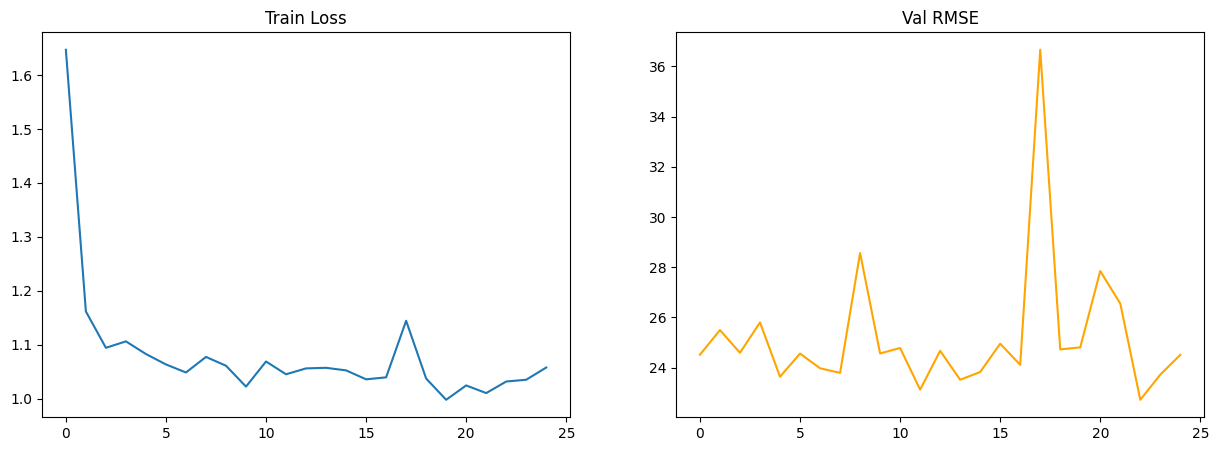

Best R²: 0.2333, Model saved to /kaggle/working/best_pasturemask_mtlnet.pth


In [ ]:
# --------------------------
# 4. Hyperparameters
# --------------------------
TOTAL_EPOCHS = 25  # 改為 40
MASK_LOSS_WEIGHT = 0.25
COVER_LOSS_WEIGHT = 0.5
GRAD_CLIP = 1.0

# --------------------------
# 5. Instantiate model & criterion
# --------------------------
model = PastureMask_MTLNet().to(device)
mse_loss = nn.MSELoss()
bce_loss = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

# --------------------------
# 6. Training Loop
# --------------------------
train_losses, val_rmses, val_r2s = [], [], []
best_r2 = -float('inf')

for epoch in range(TOTAL_EPOCHS):
    model.train()
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{TOTAL_EPOCHS}")
    
    for imgs, targets_scaled, _ in pbar:
        imgs = imgs.to(device)
        targets = targets_scaled.to(device).view(-1, 1)  # ✅ 修正 target shape
        optimizer.zero_grad()
        out_biomass, out_cover, learned_mask = model(imgs)

        # pseudo mask
        pseudo_mask = get_pseudo_green_mask(imgs)
        pseudo_mask_resized = F.interpolate(pseudo_mask, size=learned_mask.shape[-2:], mode='bilinear')
        pseudo_cover = pseudo_mask_resized.mean(dim=(2,3), keepdim=True)

        # losses
        loss_biomass = mse_loss(out_biomass, targets)
        loss_cover   = mse_loss(out_cover, pseudo_cover)
        loss_mask    = bce_loss(learned_mask, pseudo_mask_resized)
        loss_total = loss_biomass + COVER_LOSS_WEIGHT*loss_cover + MASK_LOSS_WEIGHT*loss_mask

        loss_total.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()
        epoch_loss += loss_total.item() * imgs.size(0)
        pbar.set_postfix({'biomass': f"{loss_biomass.item():.4f}", 'cover': f"{loss_cover.item():.4f}", 'mask': f"{loss_mask.item():.4f}"})

        # 清理記憶體
        del pseudo_mask, pseudo_mask_resized, learned_mask
        torch.cuda.empty_cache()
    
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # --------------------------
    # Validation
    # --------------------------
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for imgs, targets_scaled, raw_targets in val_loader:
            imgs = imgs.to(device)
            targets = targets_scaled.to(device).view(-1, 1)  # ✅ 修正 target shape
            out_biomass, _, _ = model(imgs)
            all_preds.append(out_biomass.cpu().numpy())
            all_targets.append(raw_targets.numpy())
            torch.cuda.empty_cache()

    all_preds = np.concatenate(all_preds).reshape(-1,1)
    preds_real = target_scaler.inverse_transform(all_preds).flatten()
    all_targets = np.concatenate(all_targets).flatten()
    preds_real = np.clip(preds_real, 0, None)
    rmse = np.sqrt(np.mean((all_targets - preds_real)**2))
    ss_res = np.sum((all_targets - preds_real)**2)
    ss_tot = np.sum((all_targets - np.mean(all_targets))**2)
    r2 = 1 - ss_res / (ss_tot + 1e-8)

    val_rmses.append(rmse)
    val_r2s.append(r2)

    save_msg = ""
    if r2 > best_r2:
        best_r2 = r2
        torch.save(model.state_dict(), "/kaggle/working/best_pasturemask_mtlnet.pth")
        save_msg = "➡ Saved Best!"

    print(f"Epoch {epoch+1} | Train Loss: {epoch_loss:.4f} | Val RMSE: {rmse:.4f} | R²: {r2:.4f} {save_msg}")

# --------------------------
# 7. Plots
# --------------------------
plt.figure(figsize=(15,5))
plt.subplot(1,2,1); plt.plot(train_losses); plt.title("Train Loss")
plt.subplot(1,2,2); plt.plot(val_rmses, color='orange'); plt.title("Val RMSE")
plt.show()
print(f"Best R²: {best_r2:.4f}, Model saved to /kaggle/working/best_pasturemask_mtlnet.pth")


🚀 開始訓練模型: Baseline (已啟用 AMP 加速)


/tmp/ipykernel_47/516629347.py:103: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # ★ 初始化混合精度 Scaler


[Baseline] Ep 1/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Loss: 2.3692 | RMSE: 51.3825 | R²: -2.9214


[Baseline] Ep 2/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2 | Loss: 0.9388 | RMSE: 24.5495 | R²: 0.1048


[Baseline] Ep 3/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3 | Loss: 0.8537 | RMSE: 23.9924 | R²: 0.1450


[Baseline] Ep 4/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4 | Loss: 0.8533 | RMSE: 23.7905 | R²: 0.1593


[Baseline] Ep 5/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5 | Loss: 0.8282 | RMSE: 23.2127 | R²: 0.1997


[Baseline] Ep 6/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6 | Loss: 0.8164 | RMSE: 24.8648 | R²: 0.0817


[Baseline] Ep 7/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7 | Loss: 0.8234 | RMSE: 23.8561 | R²: 0.1547


[Baseline] Ep 8/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8 | Loss: 0.8050 | RMSE: 22.8165 | R²: 0.2268


[Baseline] Ep 9/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9 | Loss: 0.8051 | RMSE: 23.6052 | R²: 0.1724


[Baseline] Ep 10/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10 | Loss: 0.7729 | RMSE: 23.8311 | R²: 0.1565


[Baseline] Ep 11/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 11 | Loss: 0.7787 | RMSE: 24.6090 | R²: 0.1005


[Baseline] Ep 12/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 12 | Loss: 0.8229 | RMSE: 23.2552 | R²: 0.1968


[Baseline] Ep 13/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 13 | Loss: 0.7868 | RMSE: 22.9525 | R²: 0.2175


[Baseline] Ep 14/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 14 | Loss: 0.7796 | RMSE: 23.3634 | R²: 0.1893


[Baseline] Ep 15/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 15 | Loss: 0.7452 | RMSE: 22.8074 | R²: 0.2274


[Baseline] Ep 16/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 16 | Loss: 0.7148 | RMSE: 22.9298 | R²: 0.2191


[Baseline] Ep 17/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 17 | Loss: 0.7249 | RMSE: 22.9550 | R²: 0.2174


[Baseline] Ep 18/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 18 | Loss: 0.7766 | RMSE: 23.7281 | R²: 0.1637


[Baseline] Ep 19/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 19 | Loss: 0.7413 | RMSE: 23.0762 | R²: 0.2091


[Baseline] Ep 20/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 20 | Loss: 0.7228 | RMSE: 23.1752 | R²: 0.2023


[Baseline] Ep 21/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 21 | Loss: 0.7430 | RMSE: 24.8919 | R²: 0.0797


[Baseline] Ep 22/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 22 | Loss: 0.7235 | RMSE: 23.2510 | R²: 0.1970


[Baseline] Ep 23/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 23 | Loss: 0.6753 | RMSE: 23.0338 | R²: 0.2120


[Baseline] Ep 24/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 24 | Loss: 0.6961 | RMSE: 23.3551 | R²: 0.1898


[Baseline] Ep 25/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 25 | Loss: 0.6869 | RMSE: 23.7007 | R²: 0.1657

🚀 開始訓練模型: SMA (已啟用 AMP 加速)


/tmp/ipykernel_47/516629347.py:103: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # ★ 初始化混合精度 Scaler


[SMA] Ep 1/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Loss: 1.4805 | RMSE: 31.4479 | R²: -0.4689


[SMA] Ep 2/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2 | Loss: 0.9272 | RMSE: 24.0801 | R²: 0.1388


[SMA] Ep 3/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3 | Loss: 0.8624 | RMSE: 23.7311 | R²: 0.1635


[SMA] Ep 4/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4 | Loss: 0.8931 | RMSE: 24.0575 | R²: 0.1404


[SMA] Ep 5/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5 | Loss: 0.8540 | RMSE: 23.1873 | R²: 0.2014


[SMA] Ep 6/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6 | Loss: 0.8546 | RMSE: 31.7187 | R²: -0.4943


[SMA] Ep 7/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7 | Loss: 0.8248 | RMSE: 25.3975 | R²: 0.0419


[SMA] Ep 8/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8 | Loss: 0.8435 | RMSE: 24.4571 | R²: 0.1116


[SMA] Ep 9/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9 | Loss: 0.7913 | RMSE: 23.8673 | R²: 0.1539


[SMA] Ep 10/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10 | Loss: 0.8180 | RMSE: 27.5911 | R²: -0.1307


[SMA] Ep 11/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 11 | Loss: 0.7853 | RMSE: 24.8260 | R²: 0.0846


[SMA] Ep 12/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 12 | Loss: 0.7658 | RMSE: 22.8623 | R²: 0.2237


[SMA] Ep 13/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 13 | Loss: 0.7435 | RMSE: 22.8098 | R²: 0.2272


[SMA] Ep 14/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 14 | Loss: 0.7431 | RMSE: 23.0914 | R²: 0.2080


[SMA] Ep 15/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 15 | Loss: 0.7298 | RMSE: 22.4608 | R²: 0.2507


[SMA] Ep 16/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 16 | Loss: 0.7306 | RMSE: 23.3938 | R²: 0.1871


[SMA] Ep 17/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 17 | Loss: 0.7546 | RMSE: 23.2449 | R²: 0.1975


[SMA] Ep 18/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 18 | Loss: 0.7524 | RMSE: 23.7026 | R²: 0.1655


[SMA] Ep 19/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 19 | Loss: 0.7589 | RMSE: 22.9382 | R²: 0.2185


[SMA] Ep 20/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 20 | Loss: 0.7592 | RMSE: 22.8100 | R²: 0.2272


[SMA] Ep 21/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 21 | Loss: 0.7826 | RMSE: 22.5885 | R²: 0.2421


[SMA] Ep 22/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 22 | Loss: 0.7375 | RMSE: 22.9525 | R²: 0.2175


[SMA] Ep 23/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 23 | Loss: 0.7020 | RMSE: 23.2751 | R²: 0.1954


[SMA] Ep 24/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 24 | Loss: 0.6974 | RMSE: 23.0698 | R²: 0.2095


[SMA] Ep 25/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 25 | Loss: 0.6989 | RMSE: 22.8151 | R²: 0.2269

🚀 開始訓練模型: MTL (已啟用 AMP 加速)


/tmp/ipykernel_47/516629347.py:103: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # ★ 初始化混合精度 Scaler


[MTL] Ep 1/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Loss: 1.8177 | RMSE: 33.3463 | R²: -0.6516


[MTL] Ep 2/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2 | Loss: 0.9189 | RMSE: 24.6015 | R²: 0.1011


[MTL] Ep 3/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3 | Loss: 0.8620 | RMSE: 24.6272 | R²: 0.0992


[MTL] Ep 4/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4 | Loss: 0.9228 | RMSE: 24.0686 | R²: 0.1396


[MTL] Ep 5/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5 | Loss: 0.8636 | RMSE: 23.7410 | R²: 0.1628


[MTL] Ep 6/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6 | Loss: 0.8408 | RMSE: 24.4393 | R²: 0.1129


[MTL] Ep 7/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7 | Loss: 0.8736 | RMSE: 23.3113 | R²: 0.1929


[MTL] Ep 8/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8 | Loss: 0.8195 | RMSE: 24.8656 | R²: 0.0816


[MTL] Ep 9/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9 | Loss: 0.8016 | RMSE: 23.3558 | R²: 0.1898


[MTL] Ep 10/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10 | Loss: 0.8250 | RMSE: 23.6112 | R²: 0.1720


[MTL] Ep 11/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 11 | Loss: 0.8153 | RMSE: 23.7525 | R²: 0.1620


[MTL] Ep 12/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 12 | Loss: 0.7764 | RMSE: 24.6416 | R²: 0.0981


[MTL] Ep 13/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 13 | Loss: 0.7685 | RMSE: 23.8361 | R²: 0.1561


[MTL] Ep 14/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 14 | Loss: 0.7477 | RMSE: 23.1575 | R²: 0.2035


[MTL] Ep 15/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 15 | Loss: 0.7725 | RMSE: 24.1202 | R²: 0.1359


[MTL] Ep 16/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 16 | Loss: 0.7226 | RMSE: 23.7199 | R²: 0.1643


[MTL] Ep 17/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 17 | Loss: 0.7616 | RMSE: 24.2145 | R²: 0.1291


[MTL] Ep 18/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 18 | Loss: 0.7400 | RMSE: 22.8265 | R²: 0.2261


[MTL] Ep 19/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 19 | Loss: 0.7123 | RMSE: 22.2723 | R²: 0.2632


[MTL] Ep 20/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 20 | Loss: 0.7027 | RMSE: 22.5720 | R²: 0.2433


[MTL] Ep 21/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 21 | Loss: 0.7220 | RMSE: 23.3984 | R²: 0.1868


[MTL] Ep 22/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 22 | Loss: 0.7692 | RMSE: 22.7754 | R²: 0.2296


[MTL] Ep 23/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 23 | Loss: 0.7209 | RMSE: 23.0494 | R²: 0.2109


[MTL] Ep 24/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 24 | Loss: 0.7304 | RMSE: 23.0251 | R²: 0.2126


[MTL] Ep 25/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 25 | Loss: 0.7059 | RMSE: 24.0549 | R²: 0.1406

🚀 開始訓練模型: PastureMask_MTLNet (已啟用 AMP 加速)


/tmp/ipykernel_47/516629347.py:103: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # ★ 初始化混合精度 Scaler


[PastureMask_MTLNet] Ep 1/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 | Loss: 1.9233 | RMSE: 45.4305 | R²: -2.0655


[PastureMask_MTLNet] Ep 2/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2 | Loss: 0.9135 | RMSE: 27.9321 | R²: -0.1588


[PastureMask_MTLNet] Ep 3/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3 | Loss: 0.8630 | RMSE: 24.5651 | R²: 0.1037


[PastureMask_MTLNet] Ep 4/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4 | Loss: 0.8748 | RMSE: 24.1229 | R²: 0.1357


[PastureMask_MTLNet] Ep 5/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5 | Loss: 0.8697 | RMSE: 23.7616 | R²: 0.1614


[PastureMask_MTLNet] Ep 6/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6 | Loss: 0.8511 | RMSE: 23.4978 | R²: 0.1799


[PastureMask_MTLNet] Ep 7/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7 | Loss: 0.8370 | RMSE: 23.9891 | R²: 0.1453


[PastureMask_MTLNet] Ep 8/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8 | Loss: 0.8278 | RMSE: 22.7494 | R²: 0.2313


[PastureMask_MTLNet] Ep 9/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9 | Loss: 0.8186 | RMSE: 23.5568 | R²: 0.1758


[PastureMask_MTLNet] Ep 10/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10 | Loss: 0.8167 | RMSE: 24.4019 | R²: 0.1156


[PastureMask_MTLNet] Ep 11/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 11 | Loss: 0.7792 | RMSE: 23.5187 | R²: 0.1784


[PastureMask_MTLNet] Ep 12/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 12 | Loss: 0.8346 | RMSE: 23.0835 | R²: 0.2086


[PastureMask_MTLNet] Ep 13/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 13 | Loss: 0.7778 | RMSE: 22.8027 | R²: 0.2277


[PastureMask_MTLNet] Ep 14/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 14 | Loss: 0.7743 | RMSE: 23.1574 | R²: 0.2035


[PastureMask_MTLNet] Ep 15/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 15 | Loss: 0.7616 | RMSE: 23.1076 | R²: 0.2069


[PastureMask_MTLNet] Ep 16/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 16 | Loss: 0.7497 | RMSE: 22.9738 | R²: 0.2161


[PastureMask_MTLNet] Ep 17/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 17 | Loss: 0.7163 | RMSE: 23.1855 | R²: 0.2016


[PastureMask_MTLNet] Ep 18/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 18 | Loss: 0.7129 | RMSE: 23.4624 | R²: 0.1824


[PastureMask_MTLNet] Ep 19/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 19 | Loss: 0.7487 | RMSE: 23.1043 | R²: 0.2071


[PastureMask_MTLNet] Ep 20/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 20 | Loss: 0.7232 | RMSE: 23.9680 | R²: 0.1468


[PastureMask_MTLNet] Ep 21/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 21 | Loss: 0.7308 | RMSE: 22.8421 | R²: 0.2250


[PastureMask_MTLNet] Ep 22/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 22 | Loss: 0.6837 | RMSE: 23.0849 | R²: 0.2085


[PastureMask_MTLNet] Ep 23/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 23 | Loss: 0.6859 | RMSE: 23.3928 | R²: 0.1872


[PastureMask_MTLNet] Ep 24/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 24 | Loss: 0.6850 | RMSE: 23.6447 | R²: 0.1696


[PastureMask_MTLNet] Ep 25/25:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipykernel_47/516629347.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 25 | Loss: 0.7049 | RMSE: 23.9231 | R²: 0.1500


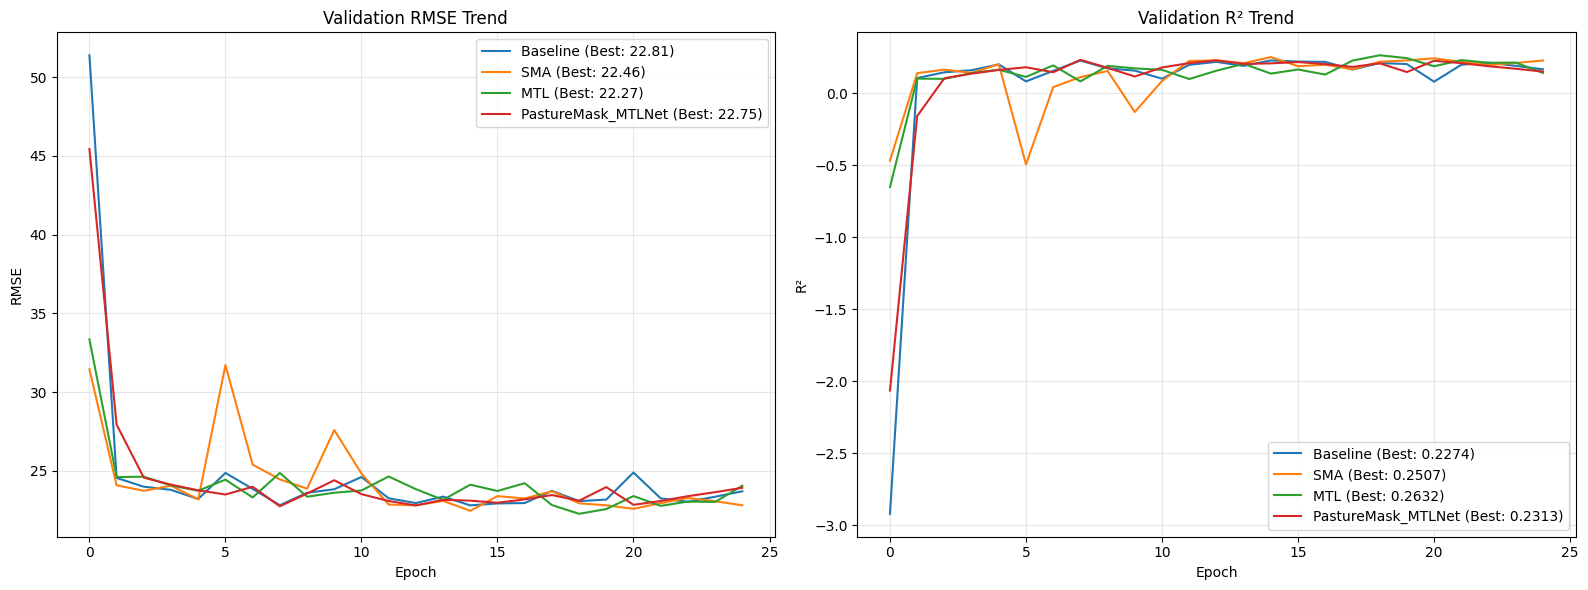

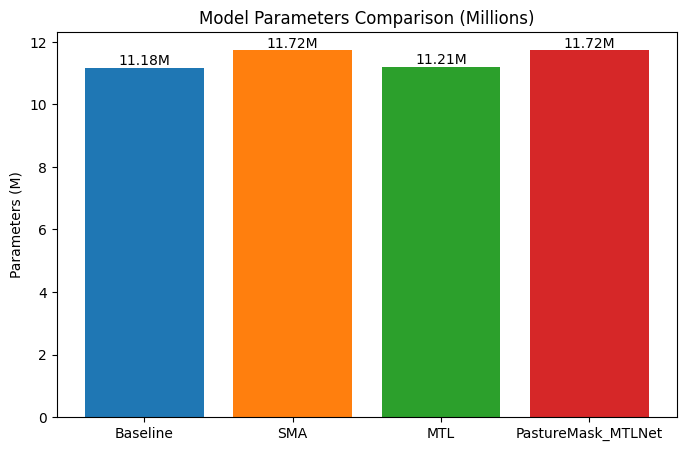


正在生成深度可視化圖...

=== 模型深度可視化分析 ===


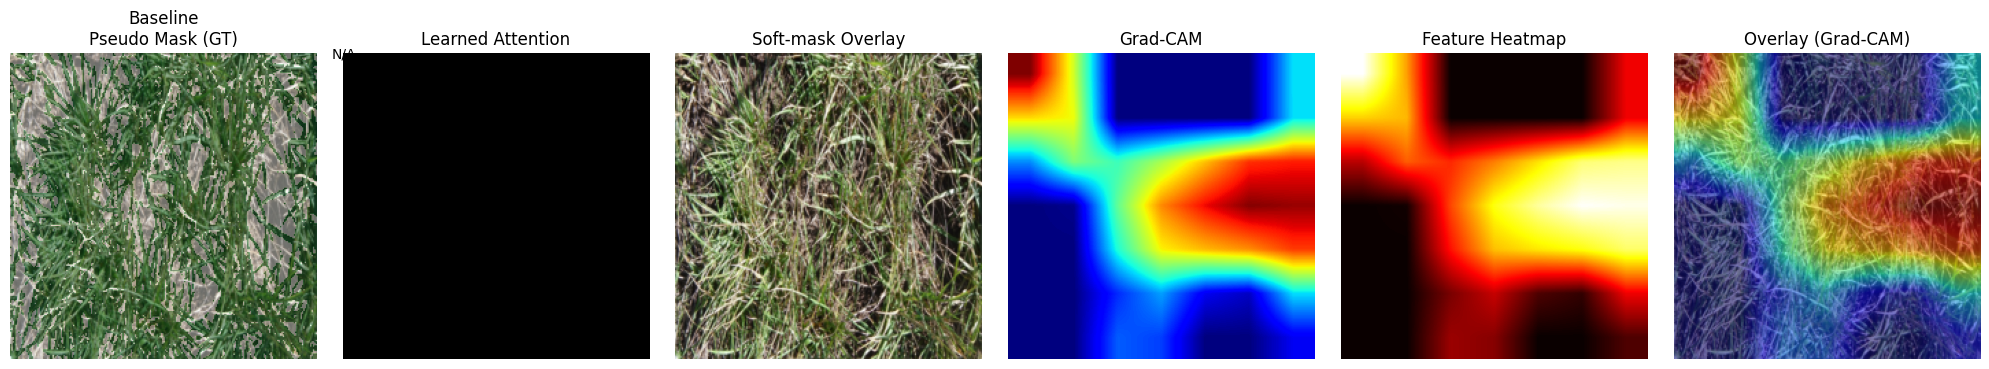

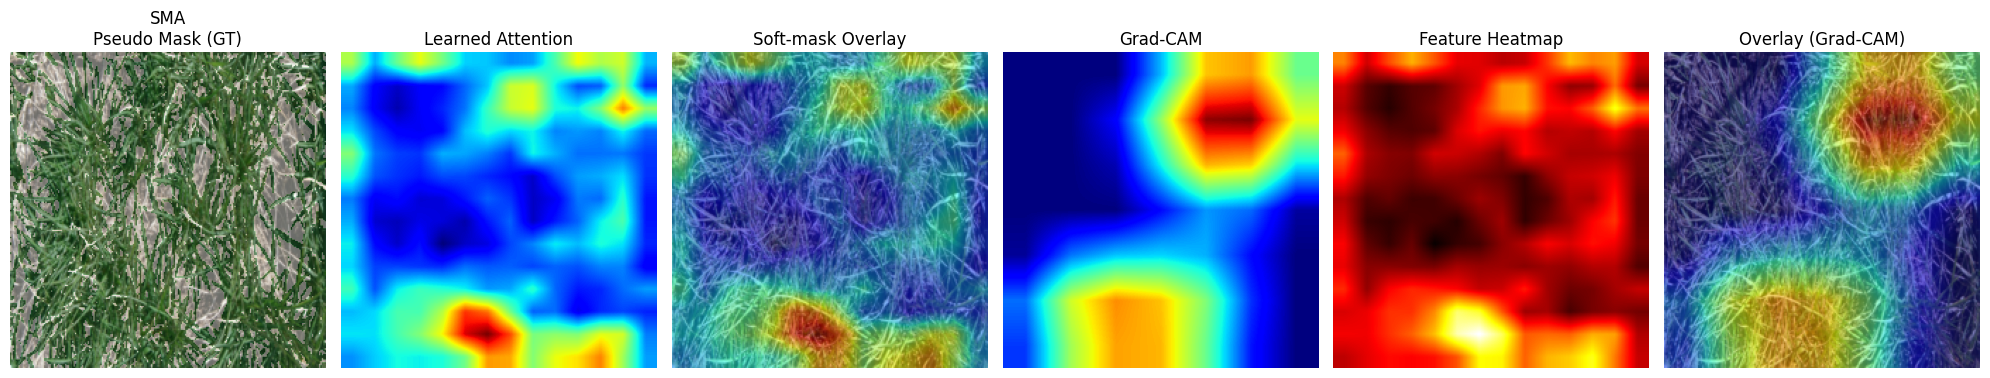

ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [] and output size of (224, 224). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from torch.cuda.amp import autocast, GradScaler # ★ 引入加速神器 ★

# ==========================================
# 1. 工具函式：計算參數量
# ==========================================
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ==========================================
# 2. 工具函式：Grad-CAM 實作
# ==========================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # 註冊 Hook
        self.handle1 = self.target_layer.register_forward_hook(self.save_activation)
        self.handle2 = self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def remove_hooks(self):
        self.handle1.remove()
        self.handle2.remove()

    def __call__(self, x):
        self.model.zero_grad()
        output = self.model(x)
        
        # 處理不同模型的輸出格式
        if isinstance(output, tuple):
            score = output[0]
        else:
            score = output
            
        # 反向傳播以計算梯度
        score.sum().backward()
        
        gradients = self.gradients
        activations = self.activations
        
        if gradients is None or activations is None:
            return np.zeros((224, 224))
            
        b, k, u, v = activations.size()
        
        # Global Average Pooling on gradients
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)
        
        # 產生 CAM
        cam = (weights * activations).sum(1, keepdim=True)
        cam = F.relu(cam) # ReLU
        cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
        
        return cam.detach().cpu().numpy()[0, 0]

# ==========================================
# 3. 工具函式：生成 Pseudo Mask (Ground Truth 概念)
# ==========================================
def get_pseudo_mask(img_tensor):
    # 假設輸入已經 Normalize，需反向還原或直接利用數值特性
    # 這裡簡單使用 ExG (Excess Green) 概念： 2G - R - B
    # 注意：img_tensor shape [3, H, W]
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(img_tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(img_tensor.device)
    img = img_tensor * std + mean # Denormalize
    
    r, g, b = img[0], img[1], img[2]
    # ExG 指標
    exg = 2 * g - r - b
    mask = (exg > 0.05).float() # 門檻值可微調
    return mask.cpu().numpy()

# ==========================================
# 4. 封裝訓練流程 (回傳 History) ★ 加入 AMP 加速 ★
# ==========================================
def train_model_with_history(name, model, train_loader, val_loader, epochs=25, lr=1e-3):
    print(f"\n🚀 開始訓練模型: {name} (已啟用 AMP 加速)")
    model = model.to(device)
    
    criterion_mse = nn.MSELoss()
    criterion_bce = nn.BCELoss() 
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
    scaler = GradScaler() # ★ 初始化混合精度 Scaler
    
    history = {
        'train_loss': [],
        'val_rmse': [],
        'val_r2': []
    }
    
    best_r2 = -float('inf')
    
    for epoch in range(epochs):
        # --- Training ---
        model.train()
        train_loss = 0
        
        # 使用 tqdm 顯示進度
        pbar = tqdm(train_loader, desc=f"[{name}] Ep {epoch+1}/{epochs}", leave=False)
        
        for imgs, targets, _ in pbar:
            imgs, targets = imgs.to(device), targets.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            
            # ★ 混合精度前向傳播 ★
            with autocast():
                output = model(imgs)
                
                if isinstance(output, tuple):
                    preds = output[0]
                    # 這裡若有輔助 Loss 可在此相加
                    loss = criterion_mse(preds, targets)
                else:
                    preds = output
                    loss = criterion_mse(preds, targets)
            
            # ★ 混合精度反向傳播 ★
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()}) # 即時顯示 Loss
            
        avg_train_loss = train_loss / len(train_loader)
        
        # --- Validation ---
        model.eval()
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for imgs, _, raw_targets in val_loader:
                imgs = imgs.to(device)
                output = model(imgs)
                
                if isinstance(output, tuple):
                    preds_scaled = output[0]
                else:
                    preds_scaled = output
                
                # 這裡假設外部有定義 target_scaler
                preds_real = target_scaler.inverse_transform(preds_scaled.cpu().numpy())
                all_preds.append(preds_real)
                all_targets.append(raw_targets.numpy())
        
        all_preds = np.concatenate(all_preds).flatten()
        all_targets = np.concatenate(all_targets).flatten()
        all_preds = np.clip(all_preds, 0, None)
        
        mse = mean_squared_error(all_targets, all_preds)
        rmse = np.sqrt(mse)
        r2 = r2_score(all_targets, all_preds)
        
        # 紀錄歷史
        history['train_loss'].append(avg_train_loss)
        history['val_rmse'].append(rmse)
        history['val_r2'].append(r2)
        
        scheduler.step(r2)
        
        if r2 > best_r2:
            best_r2 = r2
            torch.save(model.state_dict(), f"/kaggle/working/best_{name}.pth")
            
        print(f"Epoch {epoch+1} | Loss: {avg_train_loss:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")

    return history, model

# ==========================================
# 5. 主執行區塊：訓練所有模型並收集數據
# ==========================================

# ⚠️ 確保類別已定義。若 Kernel 重啟，請先跑前面定義 class 的 cell
models_to_train = {}
try:
    # 嘗試實例化模型 (請確保這些 Class 已經執行過定義了)
    models_to_train["Baseline"] = ResNet18_Baseline()
    models_to_train["SMA"] = SMA_ResNet18()
    models_to_train["MTL"] = MTL_ResNet18()
    models_to_train["PastureMask_MTLNet"] = PastureMask_MTLNet()
except NameError as e:
    print(f"❌ 錯誤: 模型類別尚未定義 ({e})。請先執行定義模型的 Cell 再執行此處。")

results_history = {}
trained_models = {}

# 只有在模型定義成功時才開始訓練
if models_to_train:
    for name, model_instance in models_to_train.items():
        hist, trained_model = train_model_with_history(name, model_instance, train_loader, val_loader, epochs=EPOCHS, lr=LR)
        results_history[name] = hist
        trained_models[name] = trained_model

    # ==========================================
    # 6. 可視化 1：RMSE 與 R² 趨勢圖
    # ==========================================
    plt.figure(figsize=(16, 6))

    # RMSE Plot
    plt.subplot(1, 2, 1)
    for name, hist in results_history.items():
        plt.plot(hist['val_rmse'], label=f"{name} (Best: {min(hist['val_rmse']):.2f})")
    plt.title("Validation RMSE Trend")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # R2 Plot
    plt.subplot(1, 2, 2)
    for name, hist in results_history.items():
        plt.plot(hist['val_r2'], label=f"{name} (Best: {max(hist['val_r2']):.4f})")
    plt.title("Validation R² Trend")
    plt.xlabel("Epoch")
    plt.ylabel("R²")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ==========================================
    # 7. 可視化 2：參數量分析
    # ==========================================
    params_data = {name: count_parameters(m) for name, m in trained_models.items()}
    names = list(params_data.keys())
    values = [v / 1e6 for v in params_data.values()] # 轉為 Million

    plt.figure(figsize=(8, 5))
    bars = plt.bar(names, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.title("Model Parameters Comparison (Millions)")
    plt.ylabel("Parameters (M)")
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}M", va='bottom', ha='center')
    plt.show()

    # ==========================================
    # 8. 可視化 3：詳細特徵圖 ★ 已修復 interpolate 錯誤 ★
    # ==========================================
    print("\n正在生成深度可視化圖...")
    model_eval_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
    sample_img, _, _ = next(iter(model_eval_loader))
    sample_img = sample_img.to(device)

    # 準備原始圖片用於顯示
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
    orig_img_disp = (sample_img[0] * std + mean).permute(1, 2, 0).cpu().numpy()
    orig_img_disp = np.clip(orig_img_disp, 0, 1)
    
    # 若有定義 get_pseudo_mask 則使用，否則跳過
    try:
        pseudo_mask = get_pseudo_mask(sample_img[0]) 
    except:
        pseudo_mask = np.zeros((224, 224))

    print("\n=== 模型深度可視化分析 ===")

    for name, model in trained_models.items():
        model.eval()
        
        # 1. 取得模型輸出
        with torch.no_grad():
            output = model(sample_img)
        
        # 2. 獲取 Learned Attention (Soft Mask) ★ 維度修正版 ★
        learned_mask = None
        if isinstance(output, tuple) and len(output) > 1:
            raw_mask = output[1]
            # 檢查維度，防止 interpolate 報錯
            if hasattr(raw_mask, 'dim'):
                if raw_mask.dim() == 4: # [B, C, H, W]
                    pass
                elif raw_mask.dim() == 3: # [B, H, W] -> [B, 1, H, W]
                    raw_mask = raw_mask.unsqueeze(1)
                
                # 插值到 224x224
                if raw_mask.shape[-1] != 224:
                    learned_mask = F.interpolate(raw_mask, size=(224, 224), mode='bilinear', align_corners=False)
                else:
                    learned_mask = raw_mask
                
                learned_mask = learned_mask[0, 0].cpu().numpy()
            else:
                learned_mask = np.zeros((224, 224))
        else:
            learned_mask = np.zeros((224, 224)) 

        # 3. 計算 Grad-CAM
        cam_map = np.zeros((224, 224))
        try:
            target_layer = None
            # 自動嘗試尋找最後一層 Conv
            if hasattr(model, 'backbone') and hasattr(model.backbone, 'layer4'):
                target_layer = model.backbone.layer4[-1]
            elif hasattr(model, 'cnn') and hasattr(model.cnn, 'layer4'):
                target_layer = model.cnn.layer4[-1]
            elif hasattr(model, 'layer4'):
                target_layer = model.layer4[-1]
                
            if target_layer:
                grad_cam = GradCAM(model, target_layer)
                cam_map = grad_cam(sample_img)
                grad_cam.remove_hooks()
        except Exception as e:
            # print(f"Skipping Grad-CAM for {name}: {e}")
            pass

        # 4. 繪圖
        plt.figure(figsize=(20, 4))
        
        # (A) GT
        plt.subplot(1, 6, 1)
        plt.imshow(orig_img_disp)
        plt.imshow(pseudo_mask, cmap='Greens', alpha=0.4)
        plt.title(f"{name}\nPseudo Mask (GT)")
        plt.axis('off')
        
        # (B) Learned Attention
        plt.subplot(1, 6, 2)
        if np.all(learned_mask == 0):
            plt.text(0.5, 0.5, "N/A", ha='center', va='center')
            plt.imshow(np.zeros_like(learned_mask), cmap='gray')
        else:
            plt.imshow(learned_mask, cmap='jet')
        plt.title("Learned Attention")
        plt.axis('off')
        
        # (C) Overlay
        plt.subplot(1, 6, 3)
        plt.imshow(orig_img_disp)
        if not np.all(learned_mask == 0):
            plt.imshow(learned_mask, cmap='jet', alpha=0.5)
        plt.title("Soft-mask Overlay")
        plt.axis('off')
        
        # (D) Grad-CAM
        plt.subplot(1, 6, 4)
        plt.imshow(cam_map, cmap='jet')
        plt.title("Grad-CAM")
        plt.axis('off')
        
        # (E) Feature Heatmap
        plt.subplot(1, 6, 5)
        focus_map = learned_mask if not np.all(learned_mask == 0) else cam_map
        plt.imshow(focus_map, cmap='hot')
        plt.title("Feature Heatmap")
        plt.axis('off')
        
        # (F) Final Overlay
        plt.subplot(1, 6, 6)
        plt.imshow(orig_img_disp)
        plt.imshow(cam_map, cmap='jet', alpha=0.5)
        plt.title("Overlay (Grad-CAM)")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
else:
    print("沒有定義模型，請先執行前面定義 ResNet18_Baseline 等類別的 Cell。")


正在生成深度可視化圖...

=== 模型深度可視化分析 ===


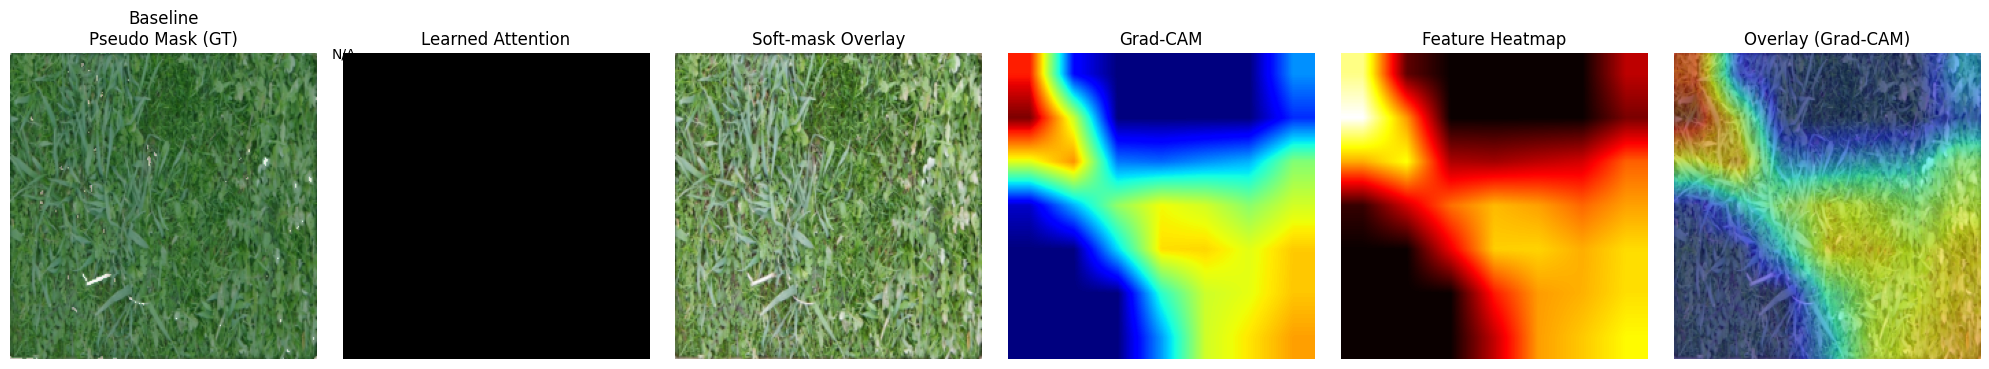

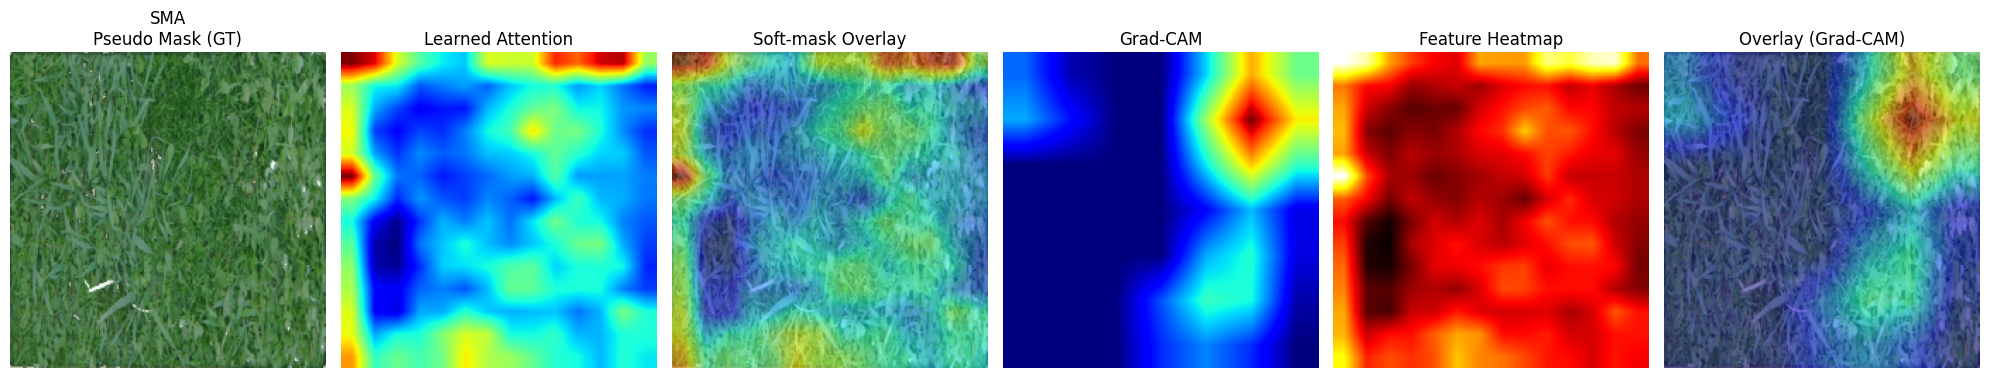

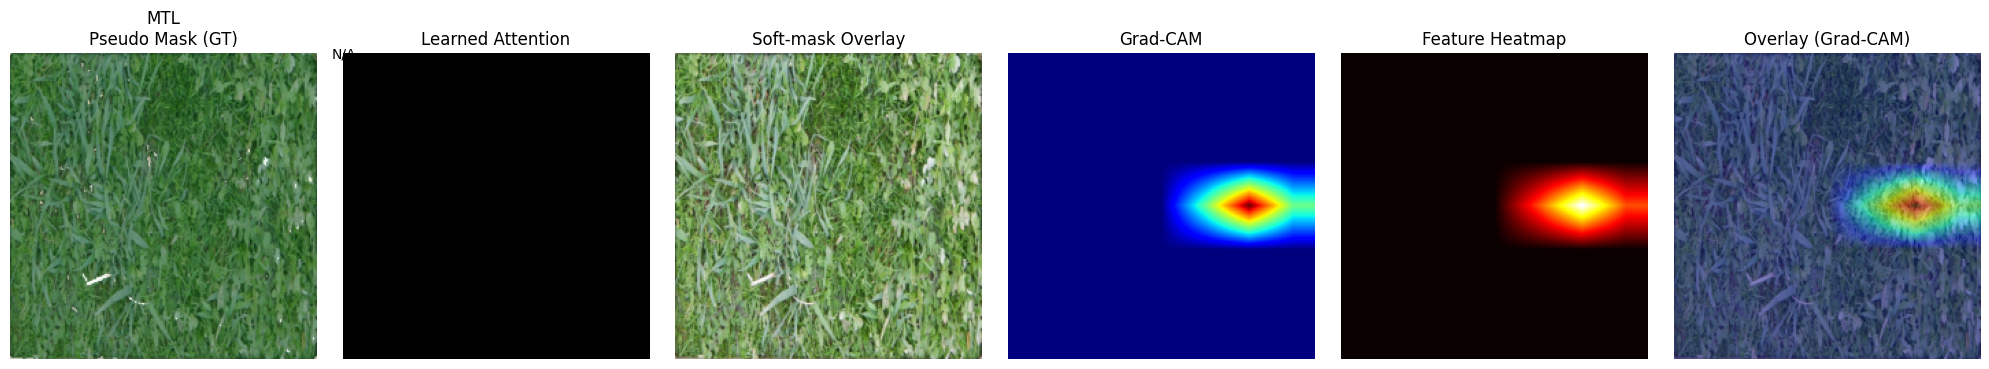

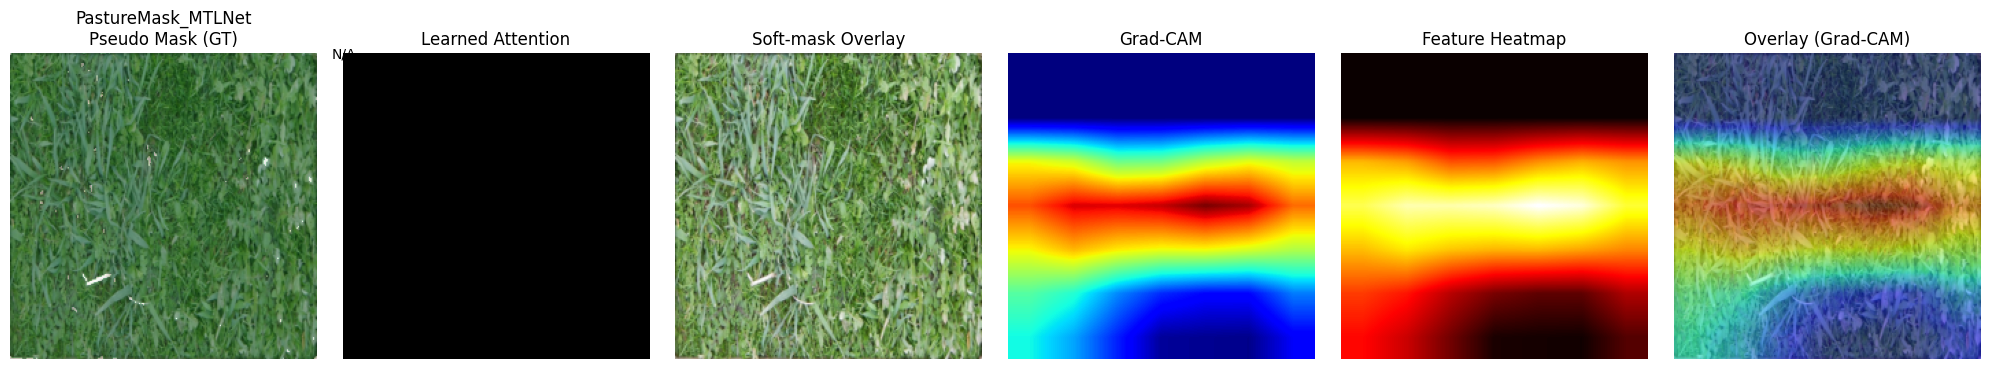

In [21]:
# ==========================================
# 8. 可視化 3：詳細特徵圖 (終極防呆修正版)
# ==========================================
print("\n正在生成深度可視化圖...")

# 重新建立 DataLoader 取樣 (避免變數汙染)
model_eval_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
sample_img, _, _ = next(iter(model_eval_loader))
sample_img = sample_img.to(device)

# 準備原始圖片用於顯示
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
orig_img_disp = (sample_img[0] * std + mean).permute(1, 2, 0).cpu().numpy()
orig_img_disp = np.clip(orig_img_disp, 0, 1)

# 若有定義 get_pseudo_mask 則使用，否則跳過
try:
    pseudo_mask = get_pseudo_mask(sample_img[0]) 
except:
    pseudo_mask = np.zeros((224, 224))

print("\n=== 模型深度可視化分析 ===")

for name, model in trained_models.items():
    model.eval()
    
    # 1. 取得模型輸出
    with torch.no_grad():
        output = model(sample_img)
    
    # 2. 獲取 Learned Attention (Soft Mask) ★ 嚴格維度檢查 ★
    learned_mask = None
    
    # 只有當 output 是 tuple 且長度 > 1 時才嘗試抓 mask
    if isinstance(output, tuple) and len(output) > 1:
        raw_mask = output[1]
        
        # 初始化有效旗標
        is_valid_mask = False
        
        if hasattr(raw_mask, 'dim'):
            if raw_mask.dim() == 4: # [B, C, H, W] -> 正常圖片
                is_valid_mask = True
            elif raw_mask.dim() == 3: # [B, H, W] -> 少一維，補上
                raw_mask = raw_mask.unsqueeze(1)
                is_valid_mask = True
        
        # 只有確認是有效圖片格式，才執行 interpolate
        if is_valid_mask:
            try:
                # 插值到 224x224
                if raw_mask.shape[-1] != 224:
                    learned_mask = F.interpolate(raw_mask, size=(224, 224), mode='bilinear', align_corners=False)
                else:
                    learned_mask = raw_mask
                
                learned_mask = learned_mask[0, 0].cpu().numpy()
            except Exception as e:
                print(f"[{name}] Mask處理失敗: {e}")
                learned_mask = np.zeros((224, 224))
        else:
            # 維度不對 (例如 2維的 [B, C])，直接給全黑，不報錯
            learned_mask = np.zeros((224, 224))
    else:
        learned_mask = np.zeros((224, 224)) 

    # 3. 計算 Grad-CAM
    cam_map = np.zeros((224, 224))
    try:
        target_layer = None
        # 自動嘗試尋找最後一層 Conv
        if hasattr(model, 'backbone') and hasattr(model.backbone, 'layer4'):
            target_layer = model.backbone.layer4[-1]
        elif hasattr(model, 'cnn') and hasattr(model.cnn, 'layer4'):
            target_layer = model.cnn.layer4[-1]
        elif hasattr(model, 'layer4'):
            target_layer = model.layer4[-1]
        elif hasattr(model, 'features'): # SMA/MTL 可能在這裡
            target_layer = model.features[-1]
            
        if target_layer:
            grad_cam = GradCAM(model, target_layer)
            cam_map = grad_cam(sample_img)
            grad_cam.remove_hooks()
    except Exception as e:
        # print(f"Skipping Grad-CAM for {name}: {e}")
        pass

    # 4. 繪圖
    plt.figure(figsize=(20, 4))
    
    # (A) GT
    plt.subplot(1, 6, 1)
    plt.imshow(orig_img_disp)
    plt.imshow(pseudo_mask, cmap='Greens', alpha=0.4)
    plt.title(f"{name}\nPseudo Mask (GT)")
    plt.axis('off')
    
    # (B) Learned Attention
    plt.subplot(1, 6, 2)
    if np.all(learned_mask == 0):
        plt.text(0.5, 0.5, "N/A", ha='center', va='center')
        plt.imshow(np.zeros_like(learned_mask), cmap='gray')
    else:
        plt.imshow(learned_mask, cmap='jet')
    plt.title("Learned Attention")
    plt.axis('off')
    
    # (C) Overlay
    plt.subplot(1, 6, 3)
    plt.imshow(orig_img_disp)
    if not np.all(learned_mask == 0):
        plt.imshow(learned_mask, cmap='jet', alpha=0.5)
    plt.title("Soft-mask Overlay")
    plt.axis('off')
    
    # (D) Grad-CAM
    plt.subplot(1, 6, 4)
    plt.imshow(cam_map, cmap='jet')
    plt.title("Grad-CAM")
    plt.axis('off')
    
    # (E) Feature Heatmap
    plt.subplot(1, 6, 5)
    focus_map = learned_mask if not np.all(learned_mask == 0) else cam_map
    plt.imshow(focus_map, cmap='hot')
    plt.title("Feature Heatmap")
    plt.axis('off')
    
    # (F) Final Overlay
    plt.subplot(1, 6, 6)
    plt.imshow(orig_img_disp)
    plt.imshow(cam_map, cmap='jet', alpha=0.5)
    plt.title("Overlay (Grad-CAM)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()